<a href="https://colab.research.google.com/github/GuillaumeMagnette/Stage_Tritons/blob/master/Impl%C3%A9mentation_Triplet_loss_stage2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Keras implementation of Triplet Loss

In [0]:
tf.enable_eager_execution()

NameError: ignored

In [0]:
#!pip install git+https://github.com/tensorflow/docs
#!git clone https://github.com/GuillaumeMagnette/Stage_Tritons.git
#!pip install numba


import urllib

#import tensorflow_docs as tfdocs
#import tensorflow_docs.plots

import tensorflow_datasets as tfds

import PIL.Image

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 5)



In [0]:
try:
  %tensorflow_version 2.x
except:
  pass

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import backend
from tensorflow.keras import layers
from tensorflow.keras import datasets
from tensorflow.keras import Sequential
from tensorflow.keras.preprocessing.image import save_img

from numpy import linalg as LA

In [0]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [0]:
import tensorflow as tf

AUTOTUNE = tf.data.experimental.AUTOTUNE



from google.colab import drive
!rm -rf /content/content
drive.mount('/content/drive')
#!cp '/content/drive/My Drive/slim.zip' slim.zip
#!unzip -q /content/drive/"My Drive"/Stage/Stage_Dataset.zip
#!unzip -q /content/drive/"My Drive"/Stage/augmentedNewts56.zip
!unzip -q /content/drive/"My Drive"/Stage/seg_database.zip
!unzip -q /content/drive/"My Drive"/Stage/databaseAugSeg.zip
!unzip -q /content/drive/"My Drive"/Stage/Database_newts.zip

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import skimage
from skimage import measure
import numpy as np
from skimage.io import imread, imsave
import matplotlib.pyplot as plt
from skimage import transform
from skimage.transform import rotate, AffineTransform, swirl, resize
from skimage.util import random_noise
from skimage.filters import gaussian
from skimage import io, img_as_float, img_as_float64
from scipy import ndimage
from pathlib import Path

from random import random, uniform

import os
import pathlib
import shutil
import pandas as pd
import cv2
from google.colab.patches import cv2_imshow


import numba
from numba import jit

In [2]:
try:
  %tensorflow_version 1.4
except:
  pass

import tensorflow as tf
#tf.logging.set_verbosity(tf.logging.ERROR)
!pip install keras==2.2.5

from google.colab import drive
!rm -rf /content/content
drive.mount('/content/drive')
#!cp '/content/drive/My Drive/slim.zip' slim.zip
#!unzip -q /content/drive/"My Drive"/Stage/Database_newts.zip
!unzip -q /content/drive/"My Drive"/Stage/aug_database_for_seg.zip

`%tensorflow_version` only switches the major version: 1.x or 2.x.
You set: `1.4`. This will be interpreted as: `1.x`.


TensorFlow 1.x selected.
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
replace aug_database_for_seg/Bascha_P01_T01_K03_F_Adult_4265_20190319190818.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [5]:
!git clone https://github.com/matterport/Mask_RCNN.git

Cloning into 'Mask_RCNN'...
remote: Enumerating objects: 956, done.
remote: Total 956 (delta 0), reused 0 (delta 0), pack-reused 956
Receiving objects: 100% (956/956), 116.76 MiB | 40.71 MiB/s, done.
Resolving deltas: 100% (566/566), done.


In [3]:


import os
import sys
import json
import datetime
import numpy as np
import skimage.draw

import os
import sys
import itertools
import math
import logging
import json
import re
import random
from collections import OrderedDict
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.lines as lines
from matplotlib.patches import Polygon


# Root directory of the project
ROOT_DIR = os.path.abspath("/content/Mask_RCNN")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
# Root directory of the project
#ROOT_DIR = os.getcwd()
#if ROOT_DIR.endswith("samples/balloon"):
    # Go up two levels to the repo root
   # ROOT_DIR = os.path.dirname(os.path.dirname(ROOT_DIR))

# Import Mask RCNN
#sys.path.append(ROOT_DIR)

import mrcnn.utils
import mrcnn.visualize as visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log



%matplotlib inline

Using TensorFlow backend.


In [0]:
# Root directory of the project
ROOT_DIR = os.path.abspath("/content/Mask_RCNN")

# Import Mask RCNN
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import model as modellib, utils

# Path to trained weights file
COCO_WEIGHTS_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_WEIGHTS_PATH):
    utils.download_trained_weights(COCO_WEIGHTS_PATH)


# Directory to save logs and model checkpoints, if not provided
# through the command line argument --logs
DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")


In [0]:
############################################################
#  Configurations
############################################################


class NewtsConfig(Config):
    """Configuration for training on the toy  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "newt"

    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 2

    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + newts

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 100

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9


In [0]:
config = NewtsConfig()
NEWTS_DIR = os.path.join(ROOT_DIR, "images_annotated")

In [0]:
class InferenceConfig(NewtsConfig):
            # Set batch size to 1 since we'll be running inference on
            # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
            GPU_COUNT = 1
            IMAGES_PER_GPU = 1

model = modellib.MaskRCNN(mode="inference", config=config,
                                  model_dir=DEFAULT_LOGS_DIR)
weights_path = '/content/drive/My Drive/Stage/mask_rcnn_newt_pattern_0060.h5'
model.load_weights(weights_path, by_name=True)

config = InferenceConfig()

Processing 1 images
image                    shape: (203, 140, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


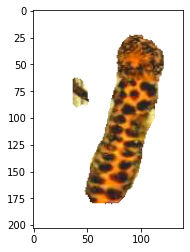

In [44]:



#measure.label()
def extract_image(img_path):

  image = skimage.io.imread(img_path, plugin='matplotlib')
  # Detect objects
  r = model.detect([image], verbose=1)[0]

  

  # Extract the greatest region 
  try:
    labels_mask = measure.label(r['masks']) 
  except ValueError:  #raised if `y` is empty.
    return image
   
  #print(labels_mask)                 
  #print(labels_mask.astype(np.uint8))
  #plt.imshow(np.squeeze(labels_mask.astype(np.uint8)))
  #regions = measure.regionprops(np.squeeze(labels_mask.astype(np.uint8)))
  try:
    regions = measure.regionprops(labels_mask)
  except ValueError:  #raised if `y` is empty.
    return image
  regions.sort(key=lambda x: x.area, reverse=True)
  #print(regions)
  #print(len(regions))
  #if (len(regions) == 0):
    #return image
  #if len(regions) > 1:
   # for rg in regions[1:]:
    #    labels_mask[rg.coords[:,0], rg.coords[:,1]] = 0


  labels_mask[labels_mask!=0] = 1
  mask = labels_mask
  #plt.imshow(np.squeeze(mask))

  if mask.shape[-1] > 0:
    # We're treating all instances as one, so collapse the mask into one layer
    mask = (np.sum(mask, -1, keepdims=True) >= 1)
    img_extracted = np.where(mask, image, 255).astype(np.uint8)
  
  # Save output
  #file_name = "newt_{:%Y%m%dT%H%M%S}.png".format(datetime.datetime.now())
  #skimage.io.imsave(file_name, img_extracted)
  plt.imshow(img_extracted)

  return img_extracted

img_path = '/content/aug_database_for_seg/Bascha_P01_T04_K11_M_Adult_345_20190519190332.jpg'
image_extracted = extract_image(img_path)

In [0]:
def segmentationImage(img_path, seg_path):
  !rm -rf /content/seg_database
  os.makedirs(seg_path)
  for img_name in os.listdir(img_path):
    
    imagePath = img_path + '/' + img_name

    if os.path.isfile(imagePath):
      img_seg = extract_image(imagePath)

      augPath = seg_path + '/' + img_name
      image = tf.keras.preprocessing.image.img_to_array(img_seg)
      plt.imsave(augPath, image/255)

segmentationImage('/content/database', '/content/seg_database')

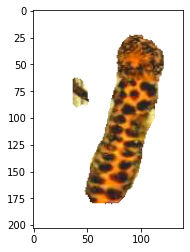

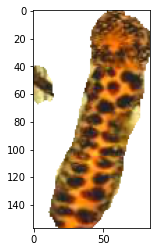

In [45]:



image = img_as_float(image_extracted)
plt.imshow(image)
plt.show()
#print(image)
#print(image.shape)
# Select all pixels almost equal to white
# (almost, because there are some edge effects in jpegs
# so the boundaries may not be exactly white)
white = np.array([1, 1, 1])
mask = np.abs(image - white).sum(axis=2) < 0.05

# Find the bounding box of those pixels
coords = np.array(np.nonzero(~mask))
top_left = np.min(coords, axis=1)
bottom_right = np.max(coords, axis=1)

out = image[top_left[0]:bottom_right[0],
            top_left[1]:bottom_right[1]]

plt.imshow(out)
plt.show()

#print(out[150,50])

In [0]:

def cropImage(img_path, seg_path):

  path = Path(seg_path)

  !rm -rf /content/seg_cropped_database
  os.makedirs(seg_path)
  for img_name in os.listdir(img_path):
    
    imagePath = img_path + '/' + img_name

    if os.path.isfile(imagePath):

      image = img_as_float(io.imread(imagePath))



      # Select all pixels almost equal to white
      # (almost, because there are some edge effects in jpegs
      # so the boundaries may not be exactly white)
      white = np.array([1, 1, 1])
      mask = np.abs(image - white).sum(axis=2) < 0.05

      # Find the bounding box of those pixels
      coords = np.array(np.nonzero(~mask))
      top_left = np.min(coords, axis=1)
      bottom_right = np.max(coords, axis=1)

      img_seg_cropped = image[top_left[0]:bottom_right[0],
            top_left[1]:bottom_right[1]]



      augPath = seg_path + '/' + img_name
      image = tf.keras.preprocessing.image.img_to_array(img_seg_cropped)
      plt.imsave(augPath, image)

cropImage('/content/seg_database', '/content/seg_cropped_database')

[[95.23543457 92.0845074  95.18651434 ... 84.63893062 49.77571554
  54.3322136 ]
 [79.61019545 61.1702917  65.59090199 ... 79.54466363 50.72982468
  48.59815147]
 [80.567785   56.54267728 50.57059974 ... 80.94772911 54.52401329
  51.46543755]
 ...
 [19.25404827 12.17091623  9.65242608 ... 37.4605422  35.5834757
  33.56602465]
 [19.25404827 12.17091623  9.65242608 ... 33.10293605 33.59146763
  34.06552327]
 [ 9.85011287  7.99163568  7.22503473 ... 34.58666522 33.59146763
  35.06180748]]


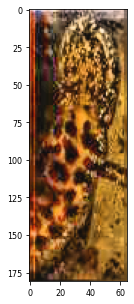

In [0]:
def random_brightness(rgb, show_result = False):
  lab = skimage.color.rgb2lab(rgb)

  #plt.imshow(lab)
  brightness = uniform(-20, 20)
  
  #print(lab[:,:,0])
  lab[:,:,0] = lab[:,:,0] + brightness
  #print(np.max(lab[:,:,0]))
  print(lab[:,:,0])
  rgb = skimage.color.lab2rgb(lab)
  if show_result:
    plt.imshow(rgb)
    plt.show()

  return rgb

imagePath = '/content/database/Bascha_P01_T06_K20_U_Adult_8012_20190719220609.jpg'
image = img_as_float(io.imread(imagePath))
#image = image/255
image = img_adapteq
lab = random_brightness(image, show_result=True)

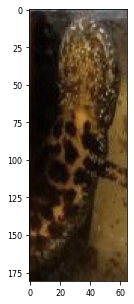

[[[0.80784314 0.82071463 0.82431865]
  [0.61568627 0.62072335 0.62192266]
  [0.63529412 0.68419196 0.68419196]
  ...
  [0.48235294 0.47572881 0.47300123]
  [0.41960784 0.4051733  0.39922967]
  [0.4627451  0.45003862 0.44602605]]

 [[0.45882353 0.41697169 0.40612121]
  [0.23137255 0.1721064  0.16222871]
  [0.21568627 0.19084464 0.19084464]
  ...
  [0.4627451  0.45368022 0.44994762]
  [0.42745098 0.41399274 0.40845111]
  [0.41568627 0.3945594  0.38677581]]

 [[0.47058824 0.42168047 0.40818867]
  [0.21176471 0.14473742 0.13133196]
  [0.16862745 0.12470947 0.1198297 ]
  ...
  [0.4745098  0.46690937 0.46377978]
  [0.45882353 0.4492705  0.44533689]
  [0.43921569 0.42111048 0.41444014]]

 ...

 [[0.10588235 0.06642068 0.04213657]
  [0.08235294 0.05075422 0.02231537]
  [0.07843137 0.04646994 0.01770465]
  ...
  [0.34509804 0.26141835 0.15084163]
  [0.34117647 0.25719992 0.1462309 ]
  [0.31764706 0.24107764 0.11856657]]

 [[0.10588235 0.06642068 0.04213657]
  [0.08235294 0.05075422 0.02231537]


In [0]:
def random_saturation(rgb, show_result = False):
  hsv = skimage.color.rgb2hsv(rgb)

  #plt.imshow(hsv)
  saturation = uniform(-0.35, 0.35)
  
  #print(hsv[:,:,1])
  hsv[:,:,1] = hsv[:,:,1] + saturation
  #print(np.max(lab[:,:,0]))
  #print(hsv[:,:,1])
  rgb = skimage.color.hsv2rgb(hsv)

  if show_result:
    plt.imshow(rgb)
    plt.show()

  return rgb

imagePath = '/content/database/Bascha_P01_T06_K20_U_Adult_8012_20190719220609.jpg'
image = img_as_float(io.imread(imagePath))
#image = image/255
#image = img_adapteq
rgb = random_saturation(image, show_result=True)
print(rgb)


/usr/local/lib/python3.6/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.6/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.6/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel.
  hist, bin_centers = histogram(image, nbins)
/usr/local/lib/python3.6/dist-packages/skimage/exposure/exposure.py:181: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You c

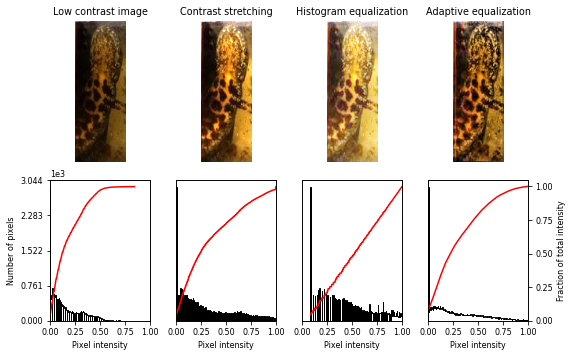

In [0]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np

from skimage import data, img_as_float
from skimage import exposure


matplotlib.rcParams['font.size'] = 8


def plot_img_and_hist(image, axes, bins=256):
    """Plot an image along with its histogram and cumulative histogram.

    """
    image = img_as_float(image)
    ax_img, ax_hist = axes
    ax_cdf = ax_hist.twinx()

    # Display image
    ax_img.imshow(image, cmap=plt.cm.gray)
    ax_img.set_axis_off()

    # Display histogram
    ax_hist.hist(image.ravel(), bins=bins, histtype='step', color='black')
    ax_hist.ticklabel_format(axis='y', style='scientific', scilimits=(0, 0))
    ax_hist.set_xlabel('Pixel intensity')
    ax_hist.set_xlim(0, 1)
    ax_hist.set_yticks([])

    # Display cumulative distribution
    img_cdf, bins = exposure.cumulative_distribution(image, bins)
    ax_cdf.plot(bins, img_cdf, 'r')
    ax_cdf.set_yticks([])

    return ax_img, ax_hist, ax_cdf


# Load an example image
img = data.moon()
img = image
# Contrast stretching
p2, p98 = np.percentile(img, (2, 98))
img_rescale = exposure.rescale_intensity(img, in_range=(p2, p98))

# Equalization
img_eq = exposure.equalize_hist(img)

# Adaptive Equalization
#img_adapteq[:,:,0] = exposure.equalize_adapthist(img[:,:,0], clip_limit=0.03)
#img_adapteq[:,:,1] = exposure.equalize_adapthist(img[:,:,1], clip_limit=0.03)
#img_adapteq[:,:,2] = exposure.equalize_adapthist(img[:,:,2], clip_limit=0.03)
img_adapteq = exposure.equalize_adapthist(img, clip_limit=0.03)

# Display results
fig = plt.figure(figsize=(8, 5))
axes = np.zeros((2, 4), dtype=np.object)
axes[0, 0] = fig.add_subplot(2, 4, 1)
for i in range(1, 4):
    axes[0, i] = fig.add_subplot(2, 4, 1+i, sharex=axes[0,0], sharey=axes[0,0])
for i in range(0, 4):
    axes[1, i] = fig.add_subplot(2, 4, 5+i)

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img, axes[:, 0])
ax_img.set_title('Low contrast image')

y_min, y_max = ax_hist.get_ylim()
ax_hist.set_ylabel('Number of pixels')
ax_hist.set_yticks(np.linspace(0, y_max, 5))

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_rescale, axes[:, 1])
ax_img.set_title('Contrast stretching')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_eq, axes[:, 2])
ax_img.set_title('Histogram equalization')

ax_img, ax_hist, ax_cdf = plot_img_and_hist(img_adapteq, axes[:, 3])
ax_img.set_title('Adaptive equalization')

ax_cdf.set_ylabel('Fraction of total intensity')
ax_cdf.set_yticks(np.linspace(0, 1, 5))

# prevent overlap of y-axis labels
fig.tight_layout()
plt.show()

In [0]:
def augmentData(img_path, aug_path):

  path = Path(seg_path)

  !rm -rf /content/seg_cropped_database
  os.makedirs(seg_path)
  for img_name in os.listdir(img_path):
    
    imagePath = img_path + '/' + img_name

    if os.path.isfile(imagePath):

      image = img_as_float(io.imread(imagePath))

      

      # Select all pixels almost equal to white
      # (almost, because there are some edge effects in jpegs
      # so the boundaries may not be exactly white)
      white = np.array([1, 1, 1])
      mask = np.abs(image - white).sum(axis=2) < 0.05

      # Find the bounding box of those pixels
      coords = np.array(np.nonzero(~mask))
      top_left = np.min(coords, axis=1)
      bottom_right = np.max(coords, axis=1)

      img_seg_cropped = image[top_left[0]:bottom_right[0],
            top_left[1]:bottom_right[1]]



      augPath = seg_path + '/' + img_name
      image = tf.keras.preprocessing.image.img_to_array(img_seg_cropped)
      plt.imsave(augPath, image)

cropImage('/content/seg_database', '/content/seg_cropped_database')

NameError: ignored

In [0]:
from sklearn import preprocessing


def pre_augmentation(img_path, preAug_path):
  
  path = Path(preAug_path)

  !rm -rf /content/databaseAug

  os.makedirs(preAug_path)
  for img_name in os.listdir(img_path):
    
    imagePath = img_path + '/' + img_name

    if os.path.isfile(imagePath):

      image = img_as_float(io.imread(imagePath))
      image = exposure.equalize_adapthist(image, clip_limit=0.03)
      image = random_saturation(image, show_result=False)
      image = random_brightness(image, show_result=False)
      print(np.max(image))
      print(np.min(image))
      image = image*255
      #plt.imshow(image)
      #plt.show()
      
      shear = uniform(-.1, .1)
      #print(shear)
      tfr = AffineTransform(shear=shear)
      sheared = transform.warp(image, tfr, order=1, preserve_range=True,mode='constant', cval=255)
      #sheared_fig = plot_side_by_side(img, sheared, 'Original', 'Sheared')
      #plt.title('shear')
      #plt.imshow(sheared)
      #v2_imshow(sheared)
      #sheared = tf.keras.preprocessing.image.img_to_array(sheared)
      #plt.imshow(sheared)
  
      strength = uniform(-1, 1)
      #print(strength)
      image = swirl(sheared, rotation=0, strength=strength, radius=500,mode='constant', cval=255)
      #print(image.shape)
      #image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) 
      #print("Augmentation par couleurs")
      
      #image = tf.image.random_brightness(image, max_delta=0.10) # Random brightness
      
      
      #image = tf.image.random_contrast(image,0.5,2)
      
      #image = tf.image.random_saturation(image,0.5,2)
      #image = tf.image.random_flip_left_right(image)
      #image = tf.image.random_flip_up_down(image)
      #print(image.shape)
      augPath = preAug_path + '/' + img_name
      #print(np.max(image))
      #print(np.min(image))
      #plt.imshow(image.astype('uint8'))
      #plt.show()

      #image[:,:,0] = preprocessing.normalize(image[:,:,0])
      #image[:,:,1] = preprocessing.normalize(image[:,:,1])
      #image[:,:,2] = preprocessing.normalize(image[:,:,2])
      
      #image = tf.keras.preprocessing.image.img_to_array(image)
      #image = img_as_float(image)
      #image = image/255
      #image = tf.keras.preprocessing.image.img_to_array(image)
      #print(image)
      plt.imsave(augPath, image/255)

img_path = '/content/database'
preAug_path = '/content/databaseAug'
pre_augmentation(img_path, preAug_path)

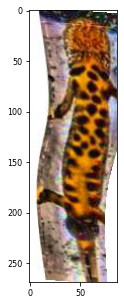

In [0]:
img_path = '/content/databaseAug/Bascha_P01_T01_K04_M_Adult_4246_20190330215714.jpg'
img = plt.imread(img_path)
plt.imshow(img)

In [0]:
!zip -r /content/aug_database_for_seg.zip /content/databaseAug

In [0]:
!unzip -q /content/drive/"My Drive"/Stage/aug_database_for_seg.zip

replace content/databaseAug/Bascha_P01_T03_K15_M_Adult_1229_20190613064950.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


Séparation en train et test set

In [0]:
def preprocess_mask(img_path, input_shape):

  img = extract_image(img_path)
  plt.figure()
  plt.imshow(img/255)

preprocess_mask(img_path, input_shape)

NameError: ignored

new augmentation with mask rcnn output

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


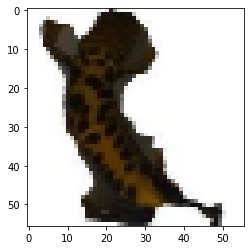

In [0]:

def preprocess_mask_rcnn(image_path, input_shape):

  #img = skimage.io.imread(image_path, plugin='matplotlib')
  image = img_as_float64(io.imread(image_path))
  
  #plt.imshow(image)

  #print(np.max(image))
  #image = tf.keras.preprocessing.image.img_to_array(img)

  #image = image/255
  #print(np.max(image))


  white = np.array([1, 1, 1])
  mask = np.abs(image - white).sum(axis=2) < 0.05
  
  # Find the bounding box of those pixels
  coords = np.array(np.nonzero(~mask))
  top_left = np.min(coords, axis=1)
  #print(top_left)
  bottom_right = np.max(coords, axis=1)
  #print(bottom_right)

  image = image[top_left[0]:bottom_right[0],
            top_left[1]:bottom_right[1]]
  
  #print(np.max(image))
  #print(np.min(image))
  #plt.imshow(image)
  #plt.show()
  
  #img = plt.imread(image_path)
  #img = tf.convert_to_tensor(img)
  #plt.imshow(img)
  ### Add borders around the image to have more room for wraping and swirling
 # h,w=img.shape[0:2]
  #shift = 20
  #base_size=h+2*shift,w+2*shift,3
# make a 3 channel image for base which is slightly larger than target img
  #base=np.zeros(base_size)
  #cv2.rectangle(base,(0,0),(w+2*shift,h+2*shift),(255,255,255),40) # really thick white rectangle
  #base[shift:h+shift,shift:w+shift]=img # this works
  #img = base
  #print(img)
  #cv2_imshow(img)

  #h,w=img.shape[0:2]

  shear = uniform(-.1, .1)
  #print(shear)
  tfr = AffineTransform(shear=shear)
  sheared = transform.warp(image, tfr, order=1, preserve_range=True,mode='constant', cval=255)
#sheared_fig = plot_side_by_side(img, sheared, 'Original', 'Sheared')
#plt.title('shear')
#plt.imshow(sheared)
#v2_imshow(sheared)
  #sheared = tf.keras.preprocessing.image.img_to_array(sheared)
  #plt.imshow(sheared)
  
  strength = uniform(-1, 1)
#print(strength)
  image = swirl(sheared, rotation=0, strength=strength, radius=500,mode='constant', cval=255)
  

  image = img_as_float64(image)
  #print(np.max(image))
  #image = image/255
  #print(np.max(image))
### image swirling using sklearn swirl
# keep strength  between -1 and 1
# maximum radius = 500
# mode = constant because in case of "wrap" some parts of the newts go the other sides of the image. Bad for the training of the neural network
  
  #print(image)
  
  #plt.imshow(image)
  #plt.show()

  #white = np.array([1, 1, 1])
  #mask = np.abs(image - white).sum(axis=2) < 0.05
  
  # Find the bounding box of those pixels
  #coords = np.array(np.nonzero(~mask))
  #top_left = np.min(coords, axis=1)
  #print(top_left)
  #bottom_right = np.max(coords, axis=1)
  #print(bottom_right)

  #image = image[top_left[0]:bottom_right[0],
           #top_left[1]:bottom_right[1]]
  #print(np.max(image))
  #print(np.min(image))
  #plt.imshow(image)
  #plt.show()
  #print("Augmentation par couleurs")
  #swirled[swirled != 255]
  
  #newt = tf.image.random_brightness(newt, max_delta=0.10) # Random brightness
  #image = tf.image.random_flip_left_right(newt)
  #image = tf.image.random_flip_up_down(image)
  #image = tf.image.random_contrast(image,0.5,2)
  #image = tf.image.random_saturation(image,0.5,2)

  height = input_shape[0]
  width = input_shape[1]
  
  if (image.shape[0] < image.shape[1]):
    image = tf.image.resize(image, [width, height])
    #print("height < width")
    image = tf.image.transpose(image)
  else:
    image = tf.image.resize(image, [height, width])
    #print("height > width")
    #print("height > width")
  #plt.imshow(image/255)
  #print(image.shape)
  #plt.imshow(tf.keras.preprocessing.image.img_to_array(image))
  #print(type(image.))
  #print(image)
  

  #plt.imshow(out)
  #plt.show()
  #augPath = '/content/augDatabase/test.jpg'
  #image = image.astype(np.uint8)
  #skimage.io.imsave(augPath, image)

  return image

input_shape = (56,56,3)
img_path = '/content/seg_database/Bascha_P01_T01_K03_M_Adult_5242_20190321032200.jpg'
img = preprocess_mask_rcnn(img_path, input_shape)
plt.imshow(img)


In [0]:
input_shape = (56,56,3)


def augmentationImage(img_path,img_aug_path, input_shape):

  
  !rm -rf /content/databaseAug
  data = pd.read_csv('/content/training.csv',)
  #data = data.to_numpy()
  labels = data.iloc[:,4]
  #print(labels.head())
  names = data.iloc[:,0]
  #print(names.head())
  #abels.head()
  labels_uniques, counts = np.unique(labels, return_counts=True)
  
  #print(labels_uniques)
  for label in labels_uniques:
    os.makedirs(img_aug_path+'/train/'+label)
    os.makedirs(img_aug_path+'/test/'+label)


  print("Création de la base de données augmentées en cours...")
  # List all files in a directory using scandir()
  basepath = img_path
  with os.scandir(basepath) as images:
    for im in images:
      #print(im.name)
      if(im.name in names.values):
        
        id = names[names == im.name].index[0]
        #id = names.loc[im.name]
        #print(id)
        label = labels.iloc[id]
        #print('label : '+label)
        id_label = np.where(labels_uniques == label)
        #print(id_label)
        imagePath = basepath + '/' + im.name
        #print(imagePath)
        #print(imagePath)
        count = counts[id_label]
        #print(count)
        #img_path = '/content/database/Bascha_P01_T01_K14_M_Adult_1024_20190605213228.jpg'
        #img = prepare_img(input_shape,imagePath)
        #image = cv2_imread(path + '/' + im.name)
        
        
        k = 0
        while (k < 20):  ######### DIVISER PAR COUNT QUAND BASE DE DONNEE COMPLETE
          image = preprocess_mask_rcnn(imagePath, input_shape)
          #image = tf.image.random_brightness(image, max_delta=0.15) # Random brightness
          #image = tf.image.random_flip_left_right(image)
          #image = tf.image.random_flip_up_down(image)
          #image = tf.image.random_contrast(image,0.5,3)
          #image = tf.image.random_saturation(image,0.5,3)
          
         
          augPath = img_aug_path+'/train/'+label+'/' + im.name[:-4] + str(k) + '.jpg'
          #augPath = img_aug_path+'/test/'+label+'/' + im.name + str(k)
          #save_img(augPath, image)
          image = tf.keras.preprocessing.image.img_to_array(image)
          image = image*255
          #cv2.imwrite(augPath,image)
          #print(image.shape)
          skimage.io.imsave(augPath,image.astype('uint8'))
          k += 1



In [0]:

input_shape = (56,56,3)
img_path = '/content/img2.png'
img = Image.open(img_path)


  #image = tf.keras.preprocessing.image.img_to_array(img)

  
#plt.imsave(augPath, image)

In [0]:
augPath = '/content/augDatabase/test'
skimage.io.imsave(augPath, img)

Old augmentation with color segmentation, canny contours, and rectangle extraction. Issue : segmentation quality not consistant because of a big variability of lightness, saturation and contrast

In [0]:
def auto_canny(image, sigma=0.33):
    # compute the median of the single channel pixel intensities
    v = np.median(image)

    # apply automatic Canny edge detection using the computed median
    lower = int(max(0, (1.0 - sigma) * v))
    upper = int(min(255, (1.0 + sigma) * v))
    edged = cv2.Canny(image, lower, upper)

    # return the edged image
    return edged

In [0]:
from random import random, uniform

# load Image
img_path = '/content/database/Bascha_P01_T05_K20_U_Larva_8359_20190717223645.jpg'
#img_path = '/content/database/Bascha_P01_T01_K14_M_Adult_1039_20190607040030.jpg'
#img_path = '/content/database/Bascha_P01_T06_K13_M_Adult_1008_20190601154259.jpg'
img_path = '/content/database/Bascha_P01_T05_K18_M_Adult_6164_20190703234211.jpg'
img_path = '/content/database/Bascha_P01_T01_K14_M_Adult_1024_20190605213228.jpg'
img_path = '/content/database/Bascha_P01_T02_K13_M_Adult_750_20190531073133.jpg'

def preprocess_newts(img_path, input_shape):
  #img = imread(img_path)
  img = cv2.imread(img_path)
# plot original Image
#plt.imshow(img)
#plt.show()
#cv2_imshow(img)


  h,w=img.shape[0:2]

### Add borders around the image to have more room for wraping and swirling
  shift = 20
  base_size=h+2*shift,w+2*shift,3
# make a 3 channel image for base which is slightly larger than target img
  base=np.zeros(base_size)
  cv2.rectangle(base,(0,0),(w+2*shift,h+2*shift),(255,255,255),40) # really thick white rectangle
  base[shift:h+shift,shift:w+shift]=img # this works
  img = base
#print(img)
#cv2_imshow(img)

  h,w=img.shape[0:2]

  #print("Augmentation par déformation")

### image shearing using sklearn.transform.AffineTransform
# try out with differnt values of shear 

  shear = uniform(-.3, .3)
  #print(shear)
  tfr = AffineTransform(shear=shear)
  sheared = transform.warp(img, tfr, order=1, preserve_range=True,mode='constant', cval=255)
#sheared_fig = plot_side_by_side(img, sheared, 'Original', 'Sheared')
#plt.title('shear')
#plt.imshow(sheared)
#v2_imshow(sheared)

### image swirling using sklearn swirl
# keep strength  between -1 and 1
# maximum radius = 500
# mode = constant because in case of "wrap" some parts of the newts go the other sides of the image. Bad for the training of the neural network
  strength = uniform(-1, 1)
#print(strength)
  swirled = swirl(sheared, rotation=0, strength=strength, radius=500,mode='constant', cval=255)
#plt.imshow(swirled)
#cv2_imshow(swirled)

  img = swirled
  #print(img.shape)
  img = img.astype(np.uint8)

  img0 = cv2.equalizeHist(img[:,:,0])
  img1 = cv2.equalizeHist(img[:,:,1])
  img2 = cv2.equalizeHist(img[:,:,2])
  img[:,:,0] = img0
  img[:,:,1] = img1
  img[:,:,2] = img2


#cv2_imshow(img)

  h,w=img.shape[0:2]



  hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS) 
  lower_yellow = np.array([5,15,25]) 
  upper_yellow = np.array([100,240,255]) 

  lower_yellow2 = np.array([160,15,25]) 
  upper_yellow2 = np.array([180,240,255]) 
#hsl(63, 20%, 81%)
  lower_black = np.array([0,0,50]) 
  upper_black = np.array([35,75,255]) 

  lower_black2 = np.array([155,0,50]) 
  upper_black2 = np.array([180,75,255]) 
# Here we are defining range of yellow color in HSL 
# This creates a mask of yellow coloured  
# objects found in the frame. 
  mask = cv2.inRange(hls, lower_yellow, upper_yellow)
  mask2 = cv2.inRange(hls, lower_yellow2, upper_yellow2)
  mask_b = cv2.inRange(hls, lower_black, upper_black) 
  mask_b2 = cv2.inRange(hls, lower_black2, upper_black2)

  mask = mask_b2+mask_b+mask+mask2
# The bitwise and of the frame and mask is done so  
# that only the blue coloured objects are highlighted  
# and stored in res 
#res = cv2.bitwise_or()
  res = cv2.bitwise_and(img,img, mask= mask) 
#cv2_imshow(img) 
#cv2_imshow(mask)
#cv2_imshow(res) 


  mask_blur = cv2.GaussianBlur(mask,(5,5),cv2.BORDER_DEFAULT)

  threshMap = cv2.threshold(mask_blur.astype("uint8"), 0, 255,
	  cv2.THRESH_BINARY | cv2.THRESH_OTSU)[1]

  kernel = np.ones((7,7),np.uint8)
  threshMap = cv2.dilate(threshMap, kernel)
  threshMap = cv2.erode(threshMap, kernel)


#cv2_imshow(mask_blur)
#cv2_imshow(threshMap)

  canny_output = auto_canny(threshMap, sigma = 0.3)
#canny_output = cv2.convertScaleAbs(canny_output)
  kernel = np.ones((9,9),np.uint8)
  threshed = cv2.dilate(canny_output,kernel)


#print(canny_output[1])
#plt.imshow(canny_output)
#plt.colorbar()
#plt.show()


## findContours(查找轮廓)
  cnts = cv2.findContours(threshed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)[-2]

#print(cnts[0])
#plt.imshow(threshed)
#plt.colorbar()
#plt.show()
#print(cnts.shape)

#new,contours, hierarchy = cv2.findContours(threshed, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
#contours= sorted(contours, key = cv2.contourArea, reverse = True)[:4]
#c=contours[0]
#print(cv2.contourArea(c))
#final = cv2.drawContours(img, [c], -1, (255,0, 0), 3)


#cnts = canny_output
#cnts = sorted(canny_output, key=cv2.contourArea)
## sorted by area(按照面积排序)
  cnts = sorted(cnts, key=cv2.contourArea)

## get the maximum's boundinRect(获取最大边缘的外接矩形)
  cnt = cnts[-1]

## create mask(创建掩模)
  mask = np.ones_like(threshMap, np.uint8)*cv2.GC_PR_BGD
  cv2.drawContours(mask, cnt, -1, cv2.GC_FGD, -1)

#print("shape of cnt: {}".format(cnt.shape))

#plt.imshow(mask)
#plt.colorbar()
#plt.show()

#new_image = cv2.bitwise_and(img,img,mask=mask)
#print(mask)
  new_image = threshMap.copy()
  new_image[mask == 2] = 0  # Set values not masked to be 0

#plt.imshow(new_image)
#plt.colorbar()
#plt.show()

#retval = cv2.contourArea(cnt)
#print(retval)

  rect = cv2.minAreaRect(cnt)
  #print("rect: {}".format(rect))

  box = cv2.boxPoints(rect)
  box = np.int0(box)

  width = int(rect[1][0])
  height = int(rect[1][1])

  src_pts = box.astype("float32")
  dst_pts = np.array([[0, height-1],
                    [0, 0],
                    [width-1, 0],
                    [width-1, height-1]], dtype="float32")
  M = cv2.getPerspectiveTransform(src_pts, dst_pts)
  warped = cv2.warpPerspective(img, M, (width, height))

#cv2_imshow(warped)

  #print("Augmentation par couleurs")
  image = tf.image.random_brightness(warped, max_delta=0.10) # Random brightness
  #image = tf.image.random_flip_left_right(image)
  #image = tf.image.random_flip_up_down(image)
  image = tf.image.random_contrast(image,0.5,2)
  image = tf.image.random_saturation(image,0.5,2)

  height = input_shape[0]
  width = input_shape[1]
  
  if (image.shape[0] < image.shape[1]):
    image = tf.image.resize(image, [width, height])
    #print("height < width")
    image = tf.image.transpose(image)
  else:
    image = tf.image.resize(image, [height, width])
    #print("height > width")

  return image

#from keras.preprocessing.image import array_to_img, img_to_array
#img = img_to_array(image)
#cv2_imshow(img.astype('uint8'))



In [0]:
input_shape = (56,56,3)


def augmentationImage(img_path,img_aug_path, input_shape):

  
  !rm -rf /content/content/databaseAug
  data = pd.read_csv('/content/content/Stage/training.csv',)
  #data = data.to_numpy()
  labels = data.iloc[:,4]
  #print(labels.head())
  names = data.iloc[:,0]
  #print(names.head())
  #abels.head()
  labels_uniques, counts = np.unique(labels, return_counts=True)
  
  #print(labels_uniques)
  for label in labels_uniques:
    os.makedirs(img_aug_path+'/train/'+label)
    os.makedirs(img_aug_path+'/test/'+label)


  print("Création de la base de données augmentées en cours...")
  # List all files in a directory using scandir()
  basepath = '/content/content/Stage/database'
  with os.scandir(basepath) as images:
    for im in images:
      #print(im.name)
      if(im.name in names.values):
        
        id = names[names == im.name].index[0]
        #id = names.loc[im.name]
        #print(id)
        label = labels.iloc[id]
        #print('label : '+label)
        id_label = np.where(labels_uniques == label)
        #print(id_label)
        imagePath = basepath + '/' + im.name
        #print(imagePath)
        
        count = counts[id_label]
        #print(count)
        #img_path = '/content/database/Bascha_P01_T01_K14_M_Adult_1024_20190605213228.jpg'
        #img = prepare_img(input_shape,imagePath)
        #image = cv2_imread(path + '/' + im.name)
        
        
        k = 0
        while (k < 20):  ######### DIVISER PAR COUNT QUAND BASE DE DONNEE COMPLETE
          #image = tf.image.random_brightness(img, max_delta=0.15) # Random brightness
          #image = tf.image.random_flip_left_right(image)
          #image = tf.image.random_flip_up_down(image)
          #image = tf.image.random_contrast(image,0.5,3)
          #image = tf.image.random_saturation(image,0.5,3)
          image = preprocess_newts(imagePath, input_shape)
         
          augPath = img_aug_path+'/train/'+label+'/' + im.name[:-4] + str(k) + '.jpg'
          #augPath = img_aug_path+'/test/'+label+'/' + im.name + str(k)
          #save_img(augPath, image)
          image = tf.keras.preprocessing.image.img_to_array(image)
          #print(image.shape)
          cv2.imwrite(augPath,image*255)
          #plt.imsave(augPath, image/255)
          k += 1



In [0]:
img_path = '/content/seg_database'
img_aug_path = '/content/databaseAug'
augmentationImage(img_path,img_aug_path,input_shape)

Séparation en train et test set

In [0]:
img = plt.imread('/content/databaseAug/train/KM00002/Bascha_P01_T02_K13_M_Adult_756_201905311224524.jpg')
plt.imshow(img)

In [0]:

train_path = '/content/databaseAug/train'
test_path = '/content/databaseAug/test'
dest1 =  pathlib.Path(test_path)
source1 = pathlib.Path(train_path)

for label in os.listdir(train_path):
  if len(os.listdir(train_path + '/' + label)) == 0: # Check if empty..
    shutil.rmtree(train_path + '/' + label) # Delete..

import fnmatch



for class_name in os.listdir(train_path):
      

      class_path = os.path.join(source1, class_name)
      class_path_test = os.path.join(dest1, class_name)
      #os.mkdir(class_path_test)
      #label_map_dict[class_name]=count_label
      imgs = fnmatch.filter(os.listdir(class_path), '*.jpg')
      nbr_img = len(imgs)

      idx = np.arange(nbr_img)
      idx_test = np.random.choice(idx, size=10, replace=False)
      print(len(os.listdir(class_path)))

      #Copie de certains éléments dans le test set
      for i in range (len(os.listdir(class_path))):
        if i in idx_test:
          print(str(class_path) + '/'+ str(os.listdir(class_path)[i]))
          shutil.copy(str(class_path) + '/'+ str(os.listdir(class_path)[i]), str(class_path_test) + '/'+ str(os.listdir(class_path)[i]))
      #Suppression des éléments copiés dans le train set
      files = os.listdir(class_path)
      for i in range (len(files)):
        if i in idx_test:
          print(str(class_path) + '/'+ str(files[i]))
          file_path = pathlib.Path(str(class_path) + '/'+ str(files[i]))
          os.remove(file_path)
          #print("removed")


for label in os.listdir(test_path):
  if len(os.listdir(test_path + '/' + label)) == 0: # Check if empty..
    shutil.rmtree(test_path + '/' + label) # Delete..

In [0]:
!zip -r /content/databaseAugSeg.zip /content/databaseAug

In [0]:
train_size = sum(len(files) for _, _, files in os.walk(r'/content/databaseAug/train'))
print(train_size)
test_size = sum(len(files) for _, _, files in os.walk(r'/content/databaseAug/test'))
print(test_size)

16870
5570


In [0]:


#width = 56
#height = 56

train_path = 'content/content/databaseAug/train'
test_path = 'content/content/databaseAug/test'

def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  print(parts[-2])
  # The second to last is the class-directory
  return parts[-2] == CLASS_NAMES

def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return img

def process_path(file_path):
  #print(file_path)
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  try:
    img = decode_img(img)
    print("decoded")
    counter +=1
  except:
    print("erreur décodage")

  return img, label

In [0]:
train_size = sum(len(files) for _, _, files in os.walk(r'/content/databaseAug/train'))
print(train_size)
test_size = sum(len(files) for _, _, files in os.walk(r'/content/databaseAug/test'))
print(test_size)

#BATCH_SIZE = 32
#input_shape = (50,35,3)
#data_dir = "/content/male"
input_shape = (56,56,3)

train_path = '/content/databaseAug/train'
test_path = '/content/databaseAug/test'

data_dir = pathlib.Path(train_path)
test_dir = pathlib.Path(test_path)

list_ds = tf.data.Dataset.list_files(str(data_dir)+'/*/*')
list_ds_test = tf.data.Dataset.list_files(str(test_dir)+'/*/*')

CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])
#print(type(CLASS_NAMES))
print(CLASS_NAMES)
#for f in list_ds.take(5):
  #print(f.numpy())
#counter = 0

def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

def augment(image,label):
  #image,label = convert(image, label)
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  #image = tf.image.rgb_to_grayscale(image)
  #image = tf.image.resize_with_crop_or_pad(image, 34, 34) # Add 6 pixels of padding
  #image = tf.image.random_crop(image, size=[28, 28, 1]) # Random crop back to 28x28
  #image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
  #image = tf.image.flip_left_right(image)

  return image,label
#Use Dataset.map to create a dataset of image, label pairs:

# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = list_ds.map(process_path, num_parallel_calls=AUTOTUNE)
labeled_ds_test = list_ds_test.map(process_path, num_parallel_calls=AUTOTUNE)

#train_size = int(0.7 * nbr_element)

#val_size = int(0.30 * nbr_element)
#test_size = int(0.15 * DATASET_SIZE)


#full_dataset = labeled_ds.shuffle()
#train_dataset = labeled_ds.take(train_size)
#test_dataset = labeled_ds.skip(train_size)
#val_dataset = test_dataset.skip(test_size)
#test_dataset = test_dataset.take(val_size)

train_dataset = labeled_ds.map(augment, num_parallel_calls=AUTOTUNE)
test_dataset = labeled_ds_test.map(augment, num_parallel_calls=AUTOTUNE)

count_label = len(os.listdir('/content/databaseAug/train'))
#print(count_label)

x_train = np.zeros((train_size,input_shape[0],input_shape[1],input_shape[2]))
y_train = np.zeros((train_size))
x_test = np.zeros((test_size,input_shape[0],input_shape[1],input_shape[2]))
y_test = np.zeros((test_size))

k=0
for image, label in labeled_ds:
  #print(label)
  x_train[k,:,:,:] = image
  y_train[k] = np.where(label)[0][0]
  k += 1
k=0
for image, label in labeled_ds_test:
  x_test[k,:,:,:] = image
  y_test[k] = np.where(label)[0][0]
  k += 1
  #print(np.where(label)[0])

#tfds_train = tf.data.Dataset.from_tensor_slices((x_train, y_train))
#tfds_train = tfds_train.batch(32)
#for i,j in tfds_train:
 # print(i)
  #print(j)
#tfds_test = tf.data.Dataset.from_tensor_slices((x_test, y_test))
#tfds_test = tfds_test.batch(32)
  #print("Image shape: ", image.numpy().shape)
  #print("Label: ", label.numpy())
#print(y_train)
dataset = []
dataset_test = []
    
#Sorting images by classes and normalize values 0=>
for n in range(count_label):
    images_class_n_train = np.asarray([row for idx,row in enumerate(x_train) if y_train[idx]==n])
    dataset.append(images_class_n_train)


    images_class_n_test = np.asarray([row for idx,row in enumerate(x_test) if y_test[idx]==n])
    dataset_test.append(images_class_n_test)

  
print("nombre de classes différentes : "+ str(count_label))
#for n in range(int(count_label*0.30)):
 #   images_class_n = np.asarray([row for idx,row in enumerate(x_test) if y_test[idx]==n])
    #print(images_class_n.shape)
  #  dataset_test.append(images_class_n/255)
        
    #images_class_n = np.asarray([row for idx,row in enumerate(x_test_origin) if y_test_origin[idx]==n])
    #dataset_test.append(images_class_n/255)
#input_shape = [width,height,3]




In [0]:
np.max(dataset[0])

1.0

In [0]:
!zip -r /content/augmentedNewts56.zip /content/content/databaseAug
#from google.colab import files
#files.download("/content/Stage_Dataset.zip")

In case of using AmphIdent outputs

In [0]:
width = 56
height = 56


def get_label(file_path):
  # convert the path to a list of path components
  #parts = str(file_path).split("/")
  parts = tf.strings.split(file_path, os.path.sep)
  #print(type(parts[-1]))
  print(parts[-1].numpy().decode("utf-8"))
  #test = str(parts)
  
  #for part in parts:
   # print(part)
  #lab = parts[-2].numpy().decode("utf-8")  + '/'+ parts[-1].numpy().decode("utf-8")
  #lab = parts[-1]
  #print(lab)
  #print(parts.  )

  #for l in np.range(lab):
    #print(l)

  i = 0
  while (parts[-1].numpy().decode("utf-8")[i] != "_"):
    i += 1
  
  #id = patterns[patterns == lab]
  #if (id.empty):
  #print(lab)

  
  # The second to last is the class-directory
  #print( tf.convert_to_tensor(lab[:i]))
  #print(CLASS_NAMES)
  #print(type(tf.convert_to_tensor(parts[-1].numpy().decode("utf-8")[:i])))
  #print(CLASS_NAMES[0])
  #print(type(CLASS_NAMES[0]))
  return tf.convert_to_tensor(parts[-1].numpy().decode("utf-8")[:i]) == CLASS_NAMES
  #assert not id.empty 
  #print(id.index)

 # id = ids.iloc[id.index]
  #print(id)
  # The second to last is the class-directory
  #print(type(tf.convert_to_tensor(id)))
  #return tf.convert_to_tensor(id)[0]
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.image.decode_jpeg(img, channels=3)
  # Use `convert_image_dtype` to convert to floats in the [0,1] range.
  img = tf.image.convert_image_dtype(img, tf.float32)
  # resize the image to the desired size.
  return tf.image.resize(img, [width, height])

def process_path(file_path):
  #print(file_path)
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  #print(img)
  try:
    img = decode_img(img)
    #print("decoded")
    counter +=1
  except:
   # print("erreur décodage")
    pass

  return img, label

In [0]:
#BATCH_SIZE = 32

#data_dir = "/content/male"

#base_path = "/content/Stage/database"


#nathan_ds = tf.data.Dataset.list_files(str(nathan_dir)+'/*')

#CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"])

#for f in list_ds.take(5):
  #print(f.numpy())
#counter = 0


ds_path = "/content/content/Stage/database/dataset_regroupe"
ds_path = pathlib.Path(ds_path)

ds_dir = os.listdir(ds_path)

CLASS_NAMES = []

for pattern in ds_dir:
  i = 0
  while (pattern[i] != "_"):
    i += 1
  CLASS_NAMES.append(pattern[:i])
  #print(pattern[:i])

CLASS_NAMES = np.array(CLASS_NAMES)
CLASS_NAMES = np.unique(CLASS_NAMES)

def show_batch(image_batch, label_batch):
  plt.figure(figsize=(10,10))
  for n in range(25):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n])
      plt.title(CLASS_NAMES[label_batch[n]==1][0].title())
      plt.axis('off')

def augment(image,label):
  #image,label = convert(image, label)
  image = tf.image.convert_image_dtype(image, tf.float32) # Cast and normalize the image to [0,1]
  #image = tf.image.resize_with_crop_or_pad(image, 34, 34) # Add 6 pixels of padding
  #image = tf.image.random_crop(image, size=[28, 28, 1]) # Random crop back to 28x28
  image = tf.image.random_brightness(image, max_delta=0.5) # Random brightness
  image = tf.image.flip_left_right(image)

  return image,label
#Use Dataset.map to create a dataset of image, label pairs:
#nathands = tf.data.Dataset.list_files(str(nathan_ds)+'/*')
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
labeled_ds = ds.map(lambda x: tf.py_function(process_path, [x], [tf.float32, tf.bool]), num_parallel_calls = AUTOTUNE)
#print(labeled_ds_nathan)
#for image,label in labeled_ds:
  #print(image)
  #print(label)
#labeled_ds_remy = remy_ds.map(process_path, num_parallel_calls=AUTOTUNE)
#train_size = int(0.7 * nbr_element)
#train_size=nbr_element-count_label*4
#test_size=count_label*4
#val_size = int(0.30 * nbr_element)
#test_size = int(0.15 * DATASET_SIZE)
#print(patterns)
train_size = patterns.size

#full_dataset = labeled_ds.shuffle()
#train_dataset = labeled_ds_nathan.take(len(nathan_ds))
#train_dataset2 = labeled_ds_remy.take(len(remy_ds))
#test_dataset = labeled_ds.skip(train_size)
#val_dataset = test_dataset.skip(test_size)
#test_dataset = test_dataset.take(val_size)
train_dataset = labeled_ds.map(augment, num_parallel_calls=AUTOTUNE)
#train_dataset2 = labeled_ds_remy.map(augment, num_parallel_calls=AUTOTUNE)
#test_dataset = labeled_ds.map(augment, num_parallel_calls=AUTOTUNE)

x_train = np.zeros((1910,width,height,3))
y_train = np.zeros((1910,1))
#x_test = np.zeros((test_size,width,height,3))
#y_test = np.zeros((test_size))

k=0
for image,label in train_dataset:
  #print(label)
  x_train[k,:,:,:] = image
  y_train[k] = np.where(label)[0][0]
  k += 1

#k=0
#for image, label in train_dataset2:
 # x_train[k,:,:,:] = image
 # y_train[k] = np.where(label)[0][0]
 # k += 1
 # print(np.where(label)[0])


print(y_train)
dataset = []

    
#Sorting images by classes and normalize values 0=>
for n in range(len(labels)):
    images_class_n_train = np.asarray([row for idx,row in enumerate(x_train) if y_train[idx]==n])
    dataset.append(images_class_n_train/255)
  
input_shape = [width,height,3]




[[481.]
 [715.]
 [380.]
 ...
 [226.]
 [476.]
 [451.]]


In [0]:
x_train = np.zeros((1910,width,height,3))
y_train = np.zeros((1910,1))
#x_test = np.zeros((test_size,width,height,3))
#y_test = np.zeros((test_size))

k=0
for image,label in train_dataset:
  #print(label)
  x_train[k,:,:,:] = image
  y_train[k] = np.where(label)[0][0]
  k += 1

#k=0
#for image, label in train_dataset2:
 # x_train[k,:,:,:] = image
 # y_train[k] = np.where(label)[0][0]
 # k += 1
 # print(np.where(label)[0])


print(y_train)
dataset = []

    
#Sorting images by classes and normalize values 0=>
for n in range(len(labels)):
    images_class_n_train = np.asarray([row for idx,row in enumerate(x_train) if y_train[idx]==n])
    dataset.append(images_class_n_train/255)
  
input_shape = [width,height,3]

[[488.]
 [489.]
 [156.]
 ...
 [ 58.]
 [194.]
 [163.]]


In [0]:


#k=0
#for image, label in labeled_ds_test:
 # x_test[k,:,:,:] = image
 # y_test[k] = np.where(label)[0][0]
 # k += 1
 # print(np.where(label)[0])
  
  #print("Image shape: ", image.numpy().shape)
  #print("Label: ", label.numpy())
print(y_train)
dataset = []
dataset_test = []
    
#Sorting images by classes and normalize values 0=>
for n in range(count_label):
    images_class_n_train = np.asarray([row for idx,row in enumerate(x_train) if y_train[idx]==n])
    dataset.append(images_class_n_train/255)


    images_class_n_test = np.asarray([row for idx,row in enumerate(x_test) if y_test[idx]==n])
    dataset_test.append(images_class_n_test/255)

  
print("nombre de classes différentes : "+ str(count_label))
#for n in range(int(count_label*0.30)):
 #   images_class_n = np.asarray([row for idx,row in enumerate(x_test) if y_test[idx]==n])
    #print(images_class_n.shape)
  #  dataset_test.append(images_class_n/255)
        
    #images_class_n = np.asarray([row for idx,row in enumerate(x_test_origin) if y_test_origin[idx]==n])
    #dataset_test.append(images_class_n/255)
input_shape = [width,height,3]




Méthode créée pour MNIST, ne pas executer dans le cas de la reconnaissance faciale

In [0]:
nb_classes = 10
count_label = nb_classes
img_rows, img_cols = 28, 28
input_shape = [img_rows, img_cols, 1]

def buildDataSet():
    """Build dataset for train and test
    
    
    returns:
        dataset : list of lengh 10 containing images for each classes of shape (?,28,28,1)
    """

    #fashion_mnist = tf.keras.datasets.fashion_mnist

    #(x_train_origin, y_train_origin), (x_test_origin, y_test_origin) = fashion_mnist.load_data()
    (x_train_origin, y_train_origin), (x_test_origin, y_test_origin) = datasets.mnist.load_data()

    assert backend.image_data_format() == 'channels_last'
    x_train_origin = x_train_origin.reshape(x_train_origin.shape[0], img_rows, img_cols, 1)
    x_test_origin = x_test_origin.reshape(x_test_origin.shape[0], img_rows, img_cols, 1)
    
    dataset_train = []
    dataset_test = []
    
    #Sorting images by classes and normalize values 0=>1
    for n in range(nb_classes):
        images_class_n = np.asarray([row for idx,row in enumerate(x_train_origin) if y_train_origin[idx]==n])
        #print(images_class_n.shape)
        dataset_train.append(images_class_n/255)
        
        images_class_n = np.asarray([row for idx,row in enumerate(x_test_origin) if y_test_origin[idx]==n])
        dataset_test.append(images_class_n/255)
    
    return dataset_train,dataset_test,x_train_origin,y_train_origin,x_test_origin,y_test_origin

dataset,dataset_test,x_train_origin,y_train_origin,x_test_origin,y_test_origin = buildDataSet()

11493376/11490434 [==============================] - 0s 0us/step


In [0]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Lambda, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import l2_normalize
from tensorflow.keras import Input, Model

def build_network_feedforward(input_shape, embeddingsize):
    '''
    Define the neural network to learn image similarity
    Input : 
            input_shape : shape of input images
            embeddingsize : vectorsize used to encode our picture   
    '''
     # Convolutional Neural Network
    network = Sequential()
    network.add(Flatten(input_shape=input_shape))
    #network.add(Dense(4096, activation='relu',
     #              kernel_regularizer=l2(1e-3),
      #             kernel_initializer='he_uniform'))
    
    
    network.add(Dense(embeddingsize, activation=None,
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer='he_uniform'))
    
    #Force the encoding to live on the d-dimentional hypershpere
    #network.add(Lambda(lambda x: K.l2_normalize(x,axis=-1)))
    
    return network



In [0]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Lambda, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import l2_normalize
from tensorflow.keras import Input, Model

def build_network(input_shape, embeddingsize):
    '''
    Define the neural network to learn image similarity
    Input : 
            input_shape : shape of input images
            embeddingsize : vectorsize used to encode our picture   
    '''
     # Convolutional Neural Network
    network = Sequential()
    network.add(Conv2D(500, (9,9), activation='relu',
                     input_shape=input_shape,
                     kernel_initializer='he_uniform',
                     ))
    network.add(MaxPooling2D())
    network.add(Dropout(0.5))
    network.add(BatchNormalization())
    network.add(Flatten())
    #network.add(Dense(4096, activation='relu',
     #              kernel_regularizer=l2(1e-3),
      #             kernel_initializer='he_uniform'))
    
    
    network.add(Dense(embeddingsize, activation=None,
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer='he_uniform'))
    
    #Force the encoding to live on the d-dimentional hypershpere
    network.add(Lambda(lambda x: l2_normalize(x,axis=-1)))
    
    return network



In [0]:
def build_network(input_shape, embeddingsize):
    '''
    Define the neural network to learn image similarity
    Input : 
            input_shape : shape of input images
            embeddingsize : vectorsize used to encode our picture   
    '''
     # Convolutional Neural Network
    network = Sequential()
    network.add(Conv2D(128, (7,7), activation='relu',
                     input_shape=input_shape,
                     kernel_initializer='he_uniform',
                     kernel_regularizer=l2(2e-4)))
    network.add(MaxPooling2D())
    network.add(Conv2D(128, (3,3), activation='relu', kernel_initializer='he_uniform',
                     kernel_regularizer=l2(2e-4)))
    network.add(MaxPooling2D())
    network.add(Conv2D(256, (3,3), activation='relu', kernel_initializer='he_uniform',
                     kernel_regularizer=l2(2e-4)))
    network.add(Flatten())
    network.add(Dense(4096, activation='relu',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer='he_uniform'))
    
    
    network.add(Dense(embeddingsize, activation=None,
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer='he_uniform'))
    
    #Force the encoding to live on the d-dimentional hypershpere
    network.add(Lambda(lambda x: l2_normalize(x,axis=-1)))
    
    return network

Ce réseau de neurones est le meilleur, ne pas executer les autres

In [0]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Lambda, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import l2_normalize
from tensorflow.keras import Input, Model

def build_network(input_shape, embeddingsize):
    '''
    Define the neural network to learn image similarity
    Input : 
            input_shape : shape of input images
            embeddingsize : vectorsize used to encode our picture   
    '''
     # Convolutional Neural Network
    network = Sequential()
    network.add(Conv2D(512, (5,5), activation='relu',
                     input_shape=input_shape,
                     kernel_initializer='he_uniform',
                     ))
    network.add(MaxPooling2D())
    network.add(Dropout(0.3))
    network.add(BatchNormalization())
    network.add(Conv2D(512, (5,5), activation='relu', kernel_initializer='he_uniform',
                     ))
    network.add(MaxPooling2D())
    network.add(Dropout(0.3))
    network.add(BatchNormalization())
    network.add(Conv2D(512, (5,5), activation='relu', kernel_initializer='he_uniform',
                     ))
    network.add(MaxPooling2D())
    #network.add(Dropout(0.5))
    
    network.add(Flatten())
    #network.add(Dense(4096, activation='relu',
     #              kernel_regularizer=l2(1e-3),
      #             kernel_initializer='he_uniform'))
    network.add(BatchNormalization())
    
    network.add(Dense(embeddingsize, activation=None,
                   kernel_initializer='he_uniform'))
    
    #Force the encoding to live on the d-dimentional hypershpere
    #network.add(Lambda(lambda x: l2_normalize(x,axis=-1)))
    
    return network



In [0]:
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Lambda, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.backend import l2_normalize
from tensorflow.keras import Input, Model

def build_network(input_shape, embeddingsize):
    '''
    Define the neural network to learn image similarity
    Input : 
            input_shape : shape of input images
            embeddingsize : vectorsize used to encode our picture   
    '''
     # Convolutional Neural Network
    network = Sequential()
    network.add(Conv2D(128, (5,5),
                     input_shape=input_shape,
                     kernel_initializer='he_uniform'))
    network.add(tf.keras.layers.LeakyReLU(alpha=0.3))
                     ##kernel_regularizer=l2(2e-4)))
    network.add(MaxPooling2D())
    network.add(Dropout(0.5))
    
    network.add(Flatten())
    network.add(Dense(2048,
                   kernel_regularizer=l2(1e-5),
                   kernel_initializer='glorot_uniform'))
    network.add(BatchNormalization())
    network.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    network.add(Dense(512,
                   kernel_regularizer=l2(1e-5),
                   kernel_initializer='glorot_uniform'))
    network.add(BatchNormalization())
    network.add(tf.keras.layers.LeakyReLU(alpha=0.3))
    network.add(Dense(embeddingsize, activation=None,
                   kernel_regularizer=l2(1e-5),
                   kernel_initializer='glorot_uniform'))
    
    #Force the encoding to live on the d-dimentional hypershpere
    network.add(Lambda(lambda x: l2_normalize(x,axis=-1)))
    
    return network


In [0]:
@jit(nopython=True)
def get_batch_moderate_random(batch_size,dataset, s="train"):
    """
    Create batch of APN triplets with a complete random strategy
    
    Arguments:
    batch_size -- integer 
    Returns:
    triplets -- list containing 3 tensors A,P,N of shape (batch_size,w,h,c), (batch_size,w,h,c,k), (batch_size,w,h,c,k,p)
    """
    
    
    m, w, h, c = dataset[0].shape
   # print(m)
    P = int(batch_size*3/4)
    K = 4

    k = 0
    # initialize result
    anchors =np.zeros((P*K, w, h, c))
    positives = np.zeros((P*K, w, h, c, K))
    negatives = np.zeros((P*K, w, h, c, K, P))
    #negatives = np.zeros((P*K, P, K, h, w, c))
    #print("PK =  " + str(P*K))
    
    #Pick one random class for anchor
    #print("nombre de classes : " + str(count_label))
    anchor_class = np.random.choice(count_label, size=P, replace=False)
    #print("longueur anchoir_class : "+str(len(anchor_class)))
    for i in range(len(anchor_class)):

      anchor = anchor_class[i]
     # print(anchor)
      nb_sample_available_for_class_A = dataset[anchor].shape[0]
      
      #Pick K different random pics for this class => A and P
      idxAP = np.random.choice(nb_sample_available_for_class_A,size=K+1,replace=False)
      #print("longueur idxAp : "+str(len(idxAP)))


      negative_class = [id for id in anchor_class if id != anchor]

      for j in range(K):
        idA = idxAP[j]
        idPx = [id for id in idxAP if id != idA]
        #print(i*K+j)
        #print("valeur de i : " + str(i))
        #print("valeur de j : " + str(j))
        #print("longueur idPx " + str(len(idPx)))
        anchors[i*K+j,:,:,:] = dataset[anchor][idA,:,:,:]
        
        for k in range(len(idPx)):
          idP = idPx[k]
          #print(idP)
          positives[i*K+j,:,:,:,k] = dataset[anchor][idP,:,:,:]

        for l in range(len(negative_class)):
            negative = negative_class[l]
            nb_sample_available_for_class_N = dataset[negative].shape[0]
            idxN = np.random.choice(nb_sample_available_for_class_N,size=K,replace=False)

            for k in range(len(idxN)):
              idN = idxN[k]
              negatives[i*K+j,:,:,:,k,l] = dataset[negative][idN,:,:,:]
          
         # if(k>0):
         #   print(positives[i*K+j,:,:,:,k]-positives[i*K+j,:,:,:,k-1])
        
        

        #Pick K different random pics for this class => N
          

        #print("i : " + str(i))
        #print("l : " + str(l))
        #print(i*K+l)

        #
        
          
            #if(k>0):
             # print(tf.subtract(negatives[i*K+l,:,:,:,k,j],negatives[i*K+l,:,:,:,k-1,j]))
        
        #Pick a random pic for this negative class => N
    #print("affichage positives batch random moderate")
    #plt.figure()
    #plt.imshow(positives[0,:,:,0,3])

    

    return anchors, positives, negatives

tripletbatch = get_batch_moderate_random(batch_size=8, dataset = dataset)



/usr/local/lib/python3.6/dist-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'dataset' of function 'get_batch_moderate_random'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-22-54689f697f20>", line 2:
@jit(nopython=True)
def get_batch_moderate_random(batch_size,dataset, s="train"):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


In [0]:

def get_batch_random(batch_size,s="train"):
    """
    Create batch of APN triplets with a complete random strategy
    
    Arguments:
    batch_size -- integer 
    Returns:
    triplets -- list containing 3 tensors A,P,N of shape (batch_size,w,h,c)
    """
    if s == 'train':
        X = dataset
    else:
        X = dataset_test

    m, w, h,c = X[0].shape
    
    nb_classes = count_label
    # initialize result
    triplets=[np.zeros((batch_size,h, w,c)) for i in range(3)]
    
    for i in range(batch_size):
        #Pick one random class for anchor
        anchor_class = np.random.randint(0, nb_classes)
        nb_sample_available_for_class_AP = X[anchor_class].shape[0]
        
        #Pick two different random pics for this class => A and P
        [idx_A,idx_P] = np.random.choice(nb_sample_available_for_class_AP,size=2,replace=False)
        
        #Pick another class for N, different from anchor_class
        negative_class = (anchor_class + np.random.randint(1,nb_classes)) % nb_classes
        nb_sample_available_for_class_N = X[negative_class].shape[0]
        
        #Pick a random pic for this negative class => N
        idx_N = np.random.randint(0, nb_sample_available_for_class_N)

        triplets[0][i,:,:,:] = X[anchor_class][idx_A,:,:,:]
        triplets[1][i,:,:,:] = X[anchor_class][idx_P,:,:,:]
        triplets[2][i,:,:,:] = X[negative_class][idx_N,:,:,:]

    return triplets


/usr/local/lib/python3.6/dist-packages/numba/ir_utils.py:2041: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'dataset' of function 'get_batch_moderate_random'.

For more information visit http://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "<ipython-input-22-54689f697f20>", line 2:
@jit(nopython=True)
def get_batch_moderate_random(batch_size,dataset, s="train"):
^

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:173: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


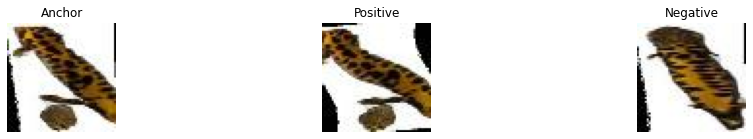

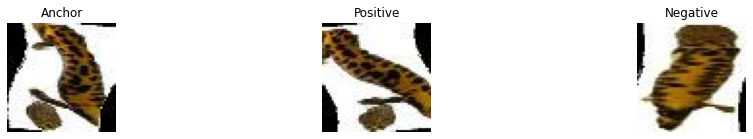

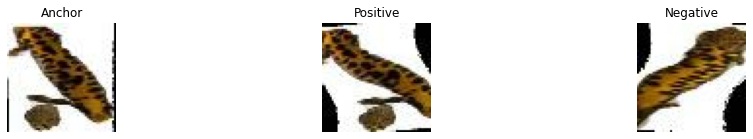

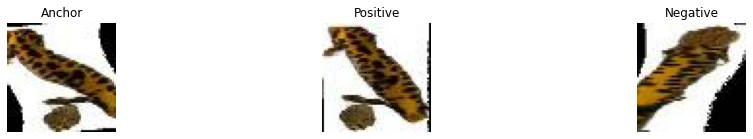

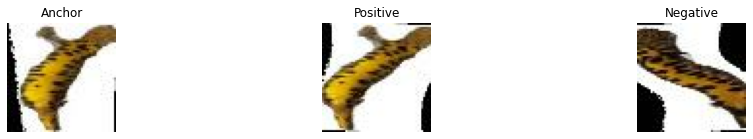

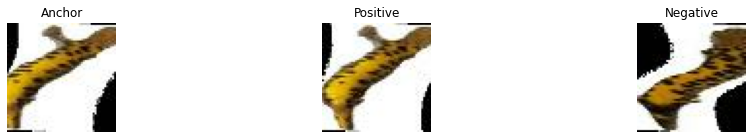

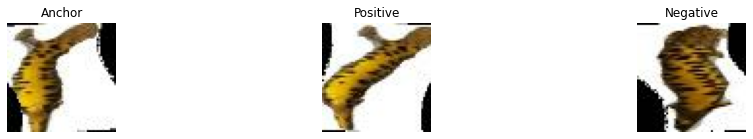

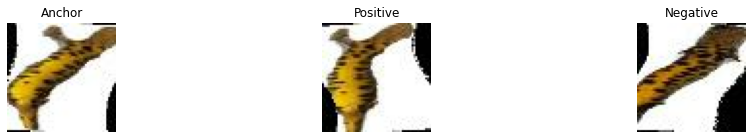

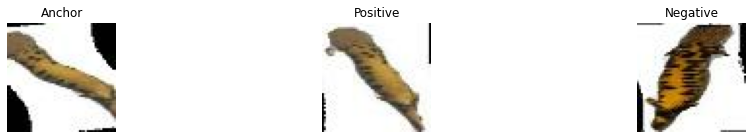

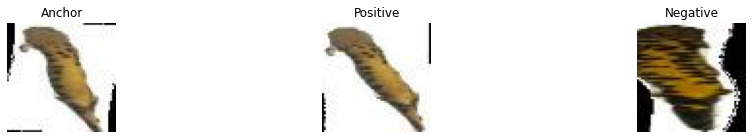

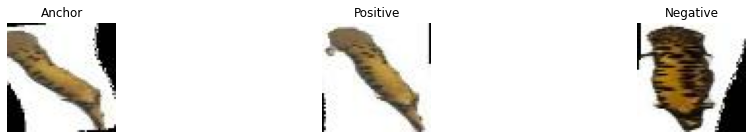

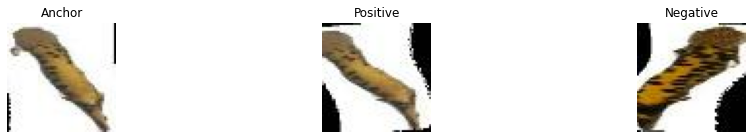

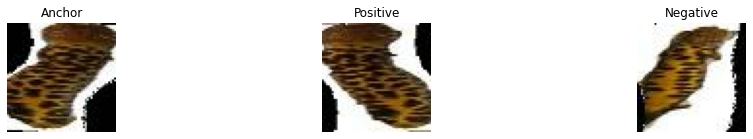

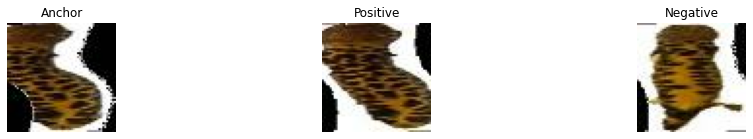

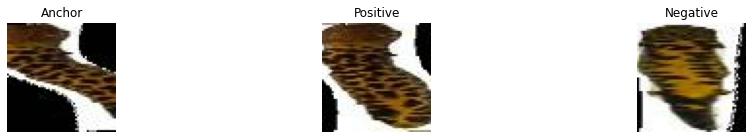

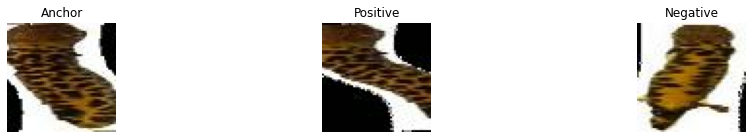

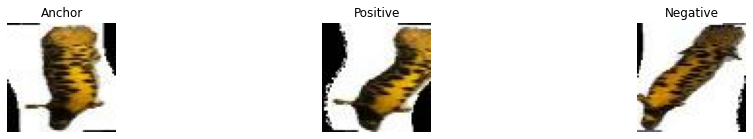

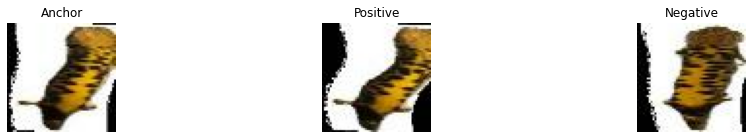

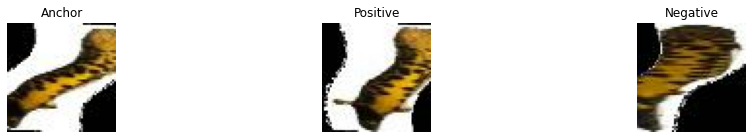

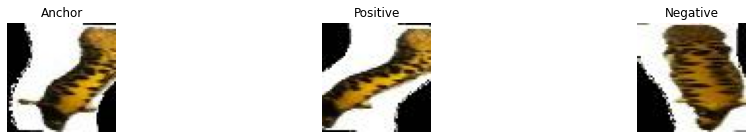

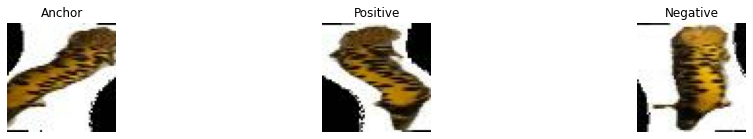

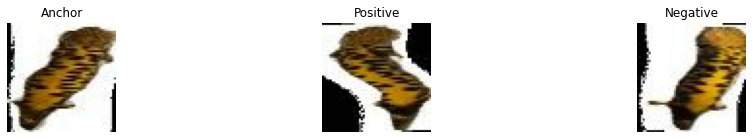

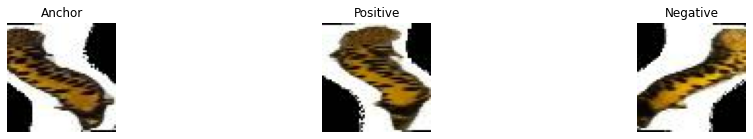

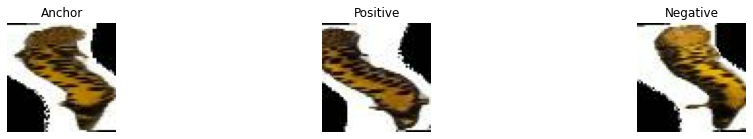

In [0]:


model = build_network(input_shape,128)


def get_batch_moderate(batch_size,network,dataset,s="train"):
    """
    Create batch of APN "moderate" triplets
    
    Arguments:
    draw_batch_size -- integer : number of initial randomly taken samples   
    hard_batchs_size -- interger : select the number of hardest samples to keep
    norm_batchs_size -- interger : number of random samples to add
    Returns:
    
    triplets -- list containing 3 tensors A,P,N of shape (hard_batchs_size+norm_batchs_size,w,h,c)
    """
    if s == 'train':
        X = dataset
    else:
        X = dataset

    m, w, h,c = X[0].shape
    
    
    #Step 1 : pick a random batch to study
    studybatch = get_batch_moderate_random(batch_size,dataset,s)
    
    
    #Compute embeddings for anchors, positive and negatives
    A = network.predict(studybatch[0])
    #print(A.shape)
    P = np.zeros((A.shape[0], A.shape[1], studybatch[1].shape[4]))
    N = np.zeros((A.shape[0], A.shape[1], studybatch[1].shape[4], studybatch[2].shape[5]))  


    for i in range(studybatch[1].shape[4]):
      P[:,:,i] = network.predict(studybatch[1][:,:,:,:,i])
     # plt.figure()
     # plt.imshow(np.squeeze(studybatch[1][0,:,:,:,i]))
      #print(studybatch[1][:,:,:,:,i])
      #if(i>0):
       # print("Pi - Pi-1")
        #print(P[:,:,i] - P[:,:,i-1])
      for j in range(studybatch[2].shape[5]):
        N[:,:,i,j] = network.predict(studybatch[2][:,:,:,:,i,j])
        #if(i>0):
         # print("Ni,j - Ni-1,j")
          #print(N[:,:,i,j] - N[:,:,i-1,j])

    
    ### Extraction des indices des distances maximales
    
    A = tf.expand_dims(A, axis = -1)
    #print(A)
    #print(P)
    dist_p = tf.math.subtract(A,P)
    #print(dist_p)
    dist_p = tf.norm(tf.math.subtract(A,P),axis = -2)
    #print(dist_p)
    selectionAP = tf.math.argmax(tf.norm(A - P,axis = -2), axis = -1)
    #print(selectionAP)
   # print(selectionAP.shape)
    #dist_p = tf.dtypes.cast(dist_p, tf.double)

    
    sub = np.zeros((A.shape[0], A.shape[1], studybatch[1].shape[4], studybatch[2].shape[5]))    
    for i in range(N.shape[3]):
      #print(A.shape)
      #print(tf.math.subtract(N[:,:,i+1,i],N[:,:,i,i]))
      sub[:,:,:,i] = tf.math.subtract(A,N[:,:,:,i])
      #print(sub[:,:,:,i])
    #A = tf.expand_dims(A, axis = -1)
    #print(sub)
    n_dist = tf.norm(sub,axis = 1)
    #print(n_dist)
    n_dist = tf.reduce_min(n_dist, axis = -2)
    #print("n_dist")
    #print(n_dist)
    selectionN = np.argmin(n_dist, axis = -1)
    #print("selectionN")
    #print(selectionN)
   # print(selectionN.shape)
    AN = tf.norm(sub,axis = -3)
    #print("AN")
    #print(AN)

    selectionPN = np.zeros((AN.shape[0]),dtype=np.int8)
    for i in range(AN.shape[0]):
      #print(AN[i,:,selectionN[i]])
      selectionPN[i] = np.argmin(AN[i,:,selectionN[i]])
      
      #print(selectionPN[i])
   # print("selectionPN")
    #print(selectionPN)
    #n_dist = tf.dtypes.cast(n_dist, tf.double)
    batch_size = studybatch[2][:,0,0,0,0,0].shape[0]
   # print(batch_size)
    width = studybatch[2][0,:,0,0,0,0].shape[0]
   # print(width)
    height = studybatch[2][0,0,:,0,0,0].shape[0]
   # print(height)
    channels = studybatch[2][0,0,0,:,0,0].shape[0]
   # print(channels)
    K = studybatch[2][0,0,0,0,:,0].shape[0]
   # print(K)
    N = studybatch[2][0,0,0,0,0,:].shape[0]
   # print(N)

    ### Création des tenseurs contenant les images sélectionnées de telles sortes à maximiser les distances AP et à minimiser les distances AN
    positives = tf.zeros((batch_size,width,height,channels))
    negatives = tf.zeros((batch_size,width,height,channels))

    #print(selectionPN)
    #print(selectionN)
    
    #print(P.shape)
    #print(N.shape)

    
    for i in range(studybatch[2][:,0,0,0,0,0].shape[0]):
      positives = studybatch[1][:,:,:,:,selectionAP[i]]
      #positives = np.squeeze(positives)
      #print(positives)
      #print(positives.shape)
      negatives = studybatch[2][:,:,:,:,selectionPN[i],selectionN[i]]
      #negatives = np.squeeze(negatives)
      #print(negatives.shape)

    #print(positives[0,:,:,0])
    #print(negatives[0,:,:,0])
    #print(positives[0,:,:,:])
    #print(negatives[0,:,:,:])
    #plt.figure()
    #plt.imshow(positives[0,:,:,0])
    #plt.figure()
    #plt.imshow(negatives[0,:,:,0])

    #studybatchloss = tf.math.reduce_sum(tf.math.log1p(tf.math.subtract(p_dist,n_dist)))
    #studybatchloss = tf.dtypes.cast(studybatchloss, tf.float32)

    triplets = [studybatch[0][:,:,:,:], positives, negatives]

    #print(NMin.shape)

    #Compute d(A,P)-d(A,N)
    #studybatchloss = np.sum(np.square(A-P),axis=1) - np.sum(np.square(A-N),axis=1)
    
    #Sort by distance (high distance first) and take the inverse
    #selection = np.argsort(studybatchloss)[::-1][:hard_batchs_size]
    
    #Draw other random samples from the batch
    #selection2 = np.random.choice(np.delete(np.arange(draw_batch_size),selection),norm_batchs_size,replace=False)
    
    #selection = np.append(selection,selection2)
    
    #triplets = [A,P,N]
    #print(triplets.shape)
    return triplets

tripletbatch = get_batch_moderate(8, model, dataset)
def drawTriplets(tripletbatch, nbmax=None):
    """display the three images for each triplets in the batch
    """
    labels = ["Anchor", "Positive", "Negative"]

    if (nbmax==None):
        nbrows = tripletbatch[0].shape[0]
    else:
        nbrows = min(nbmax,tripletbatch[0].shape[0])
                 
    for row in range(nbrows):
        fig=plt.figure(figsize=(16,2))
    
        for i in range(3):
            subplot = fig.add_subplot(1,3,i+1)
            plt.axis("off")
            triplet = tripletbatch[i][row,:,:,:]

            plt.imshow(triplet)
            subplot.title.set_text(labels[i])

drawTriplets(tripletbatch=tripletbatch)



Semi-hard

In [0]:
def compute_dist(a,b):
    return np.sum(np.square(a-b))

def get_batch_hard(draw_batch_size,hard_batchs_size,norm_batchs_size,network,s="train"):
    """
    Create batch of APN "hard" triplets
    
    Arguments:
    draw_batch_size -- integer : number of initial randomly taken samples   
    hard_batchs_size -- interger : select the number of hardest samples to keep
    norm_batchs_size -- interger : number of random samples to add
    Returns:
    triplets -- list containing 3 tensors A,P,N of shape (hard_batchs_size+norm_batchs_size,w,h,c)
    """
    if s == 'train':
        X = dataset
    else:
        X = dataset_test

    m, w, h,c = X[0].shape
    
    
    #Step 1 : pick a random batch to study
    studybatch = get_batch_random(draw_batch_size,s)
    
    #Step 2 : compute the loss with current network : d(A,P)-d(A,N). The alpha parameter here is omited here since we want only to order them
    studybatchloss = np.zeros((draw_batch_size))
    
    #Compute embeddings for anchors, positive and negatives
    A = network.predict(studybatch[0])
    P = network.predict(studybatch[1])
    N = network.predict(studybatch[2])
    
    #Compute d(A,P)-d(A,N)
    studybatchloss = np.sum(np.square(A-P),axis=1) - np.sum(np.square(A-N),axis=1)
    
    #Sort by distance (high distance first) and take the 
    selection = np.argsort(studybatchloss)[::-1][:hard_batchs_size]
    
    #Draw other random samples from the batch
    selection2 = np.random.choice(np.delete(np.arange(draw_batch_size),selection),norm_batchs_size,replace=False)
    
    selection = np.append(selection,selection2)
    
    triplets = [studybatch[0][selection,:,:,:], studybatch[1][selection,:,:,:], studybatch[2][selection,:,:,:]]
    
    return triplets

In [0]:

class TripletLossLayerModerate(layers.Layer):
    def __init__(self, **kwargs):
        #self.alpha = alpha
        super(TripletLossLayerModerate, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        A, P, N = inputs
        
        p_dist = tf.norm(A - P,axis = -1)
        n_dist = tf.norm(A - N,axis = -1)
        
        #tripletLoss = tf.math.reduce_sum(tf.math.add(self.alpha,tf.math.subtract(p_dist,n_dist)))

        #Utilisation de la formule de batch_hard du papier avec marge douce
        tripletLoss = tf.math.reduce_sum(tf.math.log1p(tf.math.exp(tf.math.subtract(p_dist,n_dist))))
        tripletLoss = tf.dtypes.cast(tripletLoss, tf.float32)
        #tripletLoss = backend.sum(backend.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
        return(tripletLoss)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss



class TripletLossLayer(layers.Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        anchor, positive, negative = inputs
        p_dist = backend.sum(backend.square(anchor-positive), axis=-1)  
        n_dist = backend.sum(backend.square(anchor-negative), axis=-1)
        return backend.sum(backend.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
    
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

Construction du modèle du papier

In [0]:
def build_model_moderate(input_shape, network, margin = 0.2):
    '''
    Define the Keras Model for training 
        Input : 
            input_shape : shape of input images
            network : Neural network to train outputing embeddings
            margin : minimal distance between Anchor-Positive and Anchor-Negative for the lossfunction (alpha)
    
    '''
    
    
     # Define the tensors for the three input images
    anchor_input = Input(input_shape, name="anchor_input")
    positive_input = Input(input_shape, name="positive_input")
    negative_input = Input(input_shape, name="negative_input") 
    
    # Generate the encodings (feature vectors) for the three images
    encoded_a = network(anchor_input)
    encoded_p = network(positive_input)
    encoded_n = network(negative_input)
    
    #TripletLoss Layer
    #loss_layer = TripletLossLayerModerate(alpha = margin, name='triplet_loss_layer')([encoded_a,encoded_p,encoded_n])
    loss_layer = TripletLossLayerModerate(name='triplet_loss_layer')([encoded_a,encoded_p,encoded_n])
    
    # Connect the inputs with the outputs
    network_train = Model(inputs=[anchor_input,positive_input,negative_input],outputs=loss_layer)
    
    # return the model
    return network_train



In [0]:

def build_model(input_shape, network, margin=0.2):
    '''
    Define the Keras Model for training 
        Input : 
            input_shape : shape of input images
            network : Neural network to train outputing embeddings
            margin : minimal distance between Anchor-Positive and Anchor-Negative for the lossfunction (alpha)
    
    '''
     # Define the tensors for the three input images
    anchor_input = Input(input_shape, name="anchor_input")
    positive_input = Input(input_shape, name="positive_input")
    negative_input = Input(input_shape, name="negative_input") 
    
    # Generate the encodings (feature vectors) for the three images
    encoded_a = network(anchor_input)
    encoded_p = network(positive_input)
    encoded_n = network(negative_input)
    
    #TripletLoss Layer
    loss_layer = TripletLossLayer(alpha=margin,name='triplet_loss_layer')([encoded_a,encoded_p,encoded_n])
    
    # Connect the inputs with the outputs
    network_train = Model(inputs=[anchor_input,positive_input,negative_input],outputs=loss_layer)
    
    # return the model
    return network_train

In [0]:

import sklearn
from sklearn.metrics import roc_auc_score, roc_curve
def compute_probs(network,X,Y):
    '''
    Input
        network : current NN to compute embeddings
        X : tensor of shape (m,w,h,1) containing pics to evaluate
        Y : tensor of shape (m,) containing true class
        
    Returns
        probs : array of shape (m,m) containing distances
    
    '''
    m = X.shape[0]
    nbevaluation = int(m*(m-1)/2)
    probs = np.zeros((nbevaluation))
    distances = np.zeros(())
    y = np.zeros((nbevaluation))
    
    #Compute all embeddings for all pics with current network
    embeddings = network.predict(X)
    
    size_embedding = embeddings.shape[1]
    
    #For each pics of our dataset
    k = 0
    for i in range(m):
            #Against all other images
            for j in range(i+1,m):
                #compute the probability of being the right decision : it should be 1 for right class, 0 for all other classes

                probs[k] = -compute_dist(embeddings[i,:],embeddings[j,:])
                if (Y[i]==Y[j]):
                    y[k] = 1
                   # print("{3}:{0} vs {1} : {2}\tSAME".format(i,j,probs[k],k))
                else:
                    y[k] = 0
                   # print("{3}:{0} vs {1} : \t\t\t{2}\tDIFF".format(i,j,probs[k],k))
                k += 1
    return probs,y
#probs,yprobs = compute_probs(network,x_test_origin[:10,:,:,:],y_test_origin[:10])

def compute_metrics(probs,yprobs):
    '''
    Returns
        fpr : Increasing false positive rates such that element i is the false positive rate of predictions with score >= thresholds[i]
        tpr : Increasing true positive rates such that element i is the true positive rate of predictions with score >= thresholds[i].
        thresholds : Decreasing thresholds on the decision function used to compute fpr and tpr. thresholds[0] represents no instances being predicted and is arbitrarily set to max(y_score) + 1
        auc : Area Under the ROC Curve metric
    '''
    # calculate AUC
    auc = roc_auc_score(yprobs, probs)
    # calculate roc curve
    fpr, tpr, thresholds = roc_curve(yprobs, probs)
    
    return fpr, tpr, thresholds,auc

In [0]:
def compute_dist(a,b):
    return np.sum(np.square(a-b))
#count_label = len(dataset)

def mean_average_precision(X,Y,network,rank):
    '''
    Returns
        MAP : the mean of the average precision of the model for each images of the dataset
    '''
    nb_classes = count_label
    print(nb_classes)
    m = X.shape[0]
    #nbtrain = 10
    nbevaluation = 50
    probs = np.zeros((nbevaluation))
    distances = np.zeros((nbevaluation,nb_classes))
    ypreds = np.zeros((nbevaluation,nb_classes))
    y = np.zeros((nbevaluation))

    
    #Compute all embeddings for all pics with current network
    embeddings = network.predict(X)
    
    size_embedding = embeddings.shape[1]

    ref_images = np.zeros((nb_classes,size_embedding))
    
    #generates embeddings for reference images
    for i in range(nb_classes):
          #print(dataset_train[i][:,0,0,1])
          #idx_ref = np.random.choice(dataset_train[i][:,0,0,1],size=200,replace=False)
          #print(idx_ref)
          #print(len(dataset_train[i][0]))
          #print(np.take(dataset_train[, idx_ref))
          selected_ref = dataset[i][:,:,:,:]
          #print(selected_ref.shape)
          #print(np.max(selected_ref))
          ref_images[i,:] = np.mean(network.predict(selected_ref),axis=0)
          #print(ref_images[i,:].shape)
    #print(np.mean(network.predict(selected_ref),axis=0).shape)
    
    test = compute_dist(ref_images[0,:],network.predict(np.expand_dims(dataset[15][0,:,:,:], axis=0)))
    print(test)
    for j in range(nbevaluation):
          print(j)
          for k in range(nb_classes):
              #print(X[j,:,:,:].shape)
              #print(np.max(ref_images[k,:]))
              distances[j,k] = compute_dist(ref_images[k,:],network.predict(np.expand_dims(X[j,:,:,:], axis=0)))
              #print(distances[j,k])
          #print(distances[j,:])
    #for i in range(nb_classes):
     #for k in range(nb_classes):
      #for j in range(nbevaluation):
              #print(X[j,:,:,:].shape)
       #       distances[j,k] = compute_dist(ref_images[i,:],network.predict(np.expand_dims(dataset[k][j,:,:,:], axis=0)))
        #      print(distances[j,k])
          #print(distances[j,:])
    #print("affichage des distances triées selon l'axe des classes")
    ypreds = np.argsort(distances,axis=-1)
    #print(ypreds[0])
    #print("affichage des distances triées selon l'axe des classes")
    #ypreds = np.flip(ypreds,axis = -1)
    #print(ypreds[0])
    ytrue = Y[:nbevaluation]
    #print(ytrue)

    AP = 0
    #print(len(ytrue))
    
    for i in range(len(ytrue)):
      #print(ypreds[i,:rank])
      #print(ytrue[i])
      print(ytrue)
      print(ypreds[i,0])
      for k in range(rank):
        
        if(ytrue[i] == ypreds[i,k]):
          AP += 1/(k+1)
    
    MAP = AP/len(ytrue)
    print(MAP)
    return MAP

def cumulative_matching_curve(X,Y,network,rank):
  
    '''
    Returns
        CMC : 
    '''
    nb_classes = count_label
    m = X.shape[0]
    nbtrain = 1000
    nbevaluation = 50
    probs = np.zeros((nbevaluation))
    distances = np.zeros((nbevaluation,nb_classes))
    ypreds = np.zeros((nbevaluation,nb_classes))
    y = np.zeros((nbevaluation))

    
    #Compute all embeddings for all pics with current network
    embeddings = network.predict(X)
    
    size_embedding = embeddings.shape[1]

    ref_images = np.zeros((nb_classes,size_embedding))
    
    #generates embeddings for reference images
    for i in range(nb_classes):
          #print(dataset_train[i][:,0,0,1])
          #idx_ref = np.random.choice(dataset_train[i][:,0,0,1],size=200,replace=False)
          #print(idx_ref)
          #print(len(dataset_train[i][0]))
          #print(np.take(dataset_train[, idx_ref))
          selected_ref = dataset[i][:nbtrain,:,:,:]
          #print(selected_ref.shape)
          ref_images[i,:] = np.mean(network.predict(selected_ref),axis=0)
          #print(ref_images[i,:].shape)
    #print(np.mean(network.predict(selected_ref),axis=0).shape)
    
    test = compute_dist(ref_images[0,:],network.predict(np.expand_dims(dataset[15][0,:,:,:], axis=0)))
    print(test)
    for j in range(nbevaluation):
          print(j)
          for k in range(nb_classes):
              #print(X[j,:,:,:].shape)
              distances[j,k] = compute_dist(ref_images[k,:],network.predict(np.expand_dims(X[j,:,:,:]/255, axis=0)))
              #print(distances[j,k])
          #print(distances[j,:])
    #for i in range(nb_classes):
     #for k in range(nb_classes):
      #for j in range(nbevaluation):
              #print(X[j,:,:,:].shape)
       #       distances[j,k] = compute_dist(ref_images[i,:],network.predict(np.expand_dims(dataset[k][j,:,:,:], axis=0)))
        #      print(distances[j,k])
          #print(distances[j,:])
    #print("affichage des distances triées selon l'axe des classes")
    ypreds = np.argsort(distances,axis=-1)
    #print(ypreds[0])
    #print("affichage des distances triées selon l'axe des classes")
    #ypreds = np.flip(ypreds,axis = -1)
    #print(ypreds[0])
    ytrue = Y[:nbevaluation]
    #print(ytrue)

    present = 0
    #print(len(ytrue))
    
    for i in range(len(ytrue)):
      #print(ypreds[i,:rank])
      #print(ytrue[i])
      for k in range(rank):
        #print(ytrue)
        #print(ypreds[i,k])
        if(ytrue[i] == ypreds[i,k]):
          present += 1
    
    CMC = present/len(ytrue)
    print(CMC)
    return CMC

    




def compute_interdist(network):
    '''
    Computes sum of distances between all classes embeddings on our reference test image: 
        d(0,1) + d(0,2) + ... + d(0,9) + d(1,2) + d(1,3) + ... d(8,9)
        A good model should have a large distance between all theses embeddings
        
    Returns:
        array of shape (nb_classes,nb_classes) 
    '''
    nb_classes = count_label
    res = np.zeros((nb_classes,nb_classes))
    
    ref_images = np.zeros((nb_classes,28,28,3))
    
    #generates embeddings for reference images
    for i in range(nb_classes):
        ref_images[i,:,:,:] = dataset[i][0,:,:,:]
    ref_embeddings = network.predict(ref_images)
    
    for i in range(nb_classes):
        for j in range(nb_classes):
            res[i,j] = compute_dist(ref_embeddings[i],ref_embeddings[j])
    return res

In [0]:
# Importing gc module 
import gc 
  
# Returns the number of 
# objects it has collected 
# and deallocated 
gc.collect() 

In [0]:
import time
embedding_size = 128
tf.keras.backend.clear_session()
model = build_network(input_shape,embedding_size)
model_trained = build_model_moderate(input_shape, model)

model_trained.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005))

n_iter = 3000
t_stop = 0
iter_stop = 0
#inter_dist = compute_interdist(model)
#print(inter_dist)

In [0]:


model_trained.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.000005, amsgrad=False))


if (iter_stop != 0):
  n_iteration = iter_stop
else:
  n_iteration = 0

evaluate_every = 10
n_val = 1000
print("Starting training process!")
print("-------------------------------------")

t_start = time.time()

if (t_stop != 0):
  t_start = t_stop

distribution = np.zeros((10,3))

plt.figure()
for i in range(1, n_iter+1):
    triplets = get_batch_moderate(14,model,dataset)
    #triplets = get_batch_hard(32,16,16,model)
    
    #print(triplets.shape)
    loss = model_trained.train_on_batch(triplets, None)
    n_iteration += 1
    t_stop = time.time()
    iter_stop = n_iteration

    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("[{3}] Time for {0} iterations: {1:.1f} mins, Train Loss: {2}".format(i, (time.time()-t_start)/60.0,np.nan_to_num(loss),n_iteration))
        
       # inter_dist = compute_interdist(model)
       # print(inter_dist)

        #MAP = mean_average_precision(x_train,y_train,model,1)
        #CMC = cumulative_matching_curve(x_test_origin,y_test_origin,model,5)
        #print("Mean Average Precision" + str(MAP))
        #print("Cumulative Matching Curve = " + str(CMC))
        #probs,yprob = compute_probs(model,x_test_origin[:n_val,:,:,:],y_test_origin[:n_val])
        #fpr, tpr, thresholds,auc = compute_metrics(probs, yprob)
        #model.predict(x_test_origin[:n_val,:,:,:])
        #plt.plot(fpr,tpr)
       # res = compute_interdist(model)
       # print(res)

Starting training process!
-------------------------------------

 ------------- 

[773] Time for 10 iterations: 6.0 mins, Train Loss: 8.18775463104248

 ------------- 

[783] Time for 20 iterations: 6.9 mins, Train Loss: 7.188763618469238

 ------------- 

[793] Time for 30 iterations: 7.7 mins, Train Loss: 11.236050605773926

 ------------- 

[803] Time for 40 iterations: 8.6 mins, Train Loss: 29.42789077758789

 ------------- 

[813] Time for 50 iterations: 9.5 mins, Train Loss: 8.607759475708008

 ------------- 

[823] Time for 60 iterations: 10.4 mins, Train Loss: 1.95681631565094

 ------------- 

[833] Time for 70 iterations: 11.2 mins, Train Loss: 23.64584732055664

 ------------- 

[843] Time for 80 iterations: 12.1 mins, Train Loss: 26.127986907958984

 ------------- 

[853] Time for 90 iterations: 13.0 mins, Train Loss: 9.919365882873535

 ------------- 

[863] Time for 100 iterations: 13.9 mins, Train Loss: 17.203292846679688

 ------------- 

[873] Time for 110 iterations:

KeyboardInterrupt: ignored

<Figure size 432x288 with 0 Axes>

In [0]:
import io
import tensorflow_datasets as tfds

results = model.predict(x_test)
# Save test embeddings for visualization in projector
np.savetxt("vecs.tsv", results, delimiter='\t')

out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for labels in y_test:
    out_m.write(str(labels) + "\n")
out_m.close()


try:
  from google.colab import files
  files.download('vecs.tsv')
  files.download('meta.tsv')
except:
  pass

In [0]:
img2 = '/content/content/databaseAug/train/KM00578/Bascha_P01_T02_K10_M_20190510210741-130.jpg'
img2 = '/content/content/databaseAug/train/KM00665/Bascha_P01_T06_K07_F_20190412053821-1314.jpg'
img2 = '/content/content/databaseAug/train/KM00658/Bascha_P01_T05_K07_F_20190422004943-2010.jpg'
img2= plt.imread(img2)
dist = compute_dist(model.predict(np.expand_dims(img/255, axis=0)), model.predict(np.expand_dims(img2/255, axis=0)))
dist

NameError: ignored

In [0]:
#print(dataset_train)
MAP = mean_average_precision(x_test,y_test,model,1)

557
517.7283037913746
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
[135.  56. 395. 509. 262. 531. 541. 291. 132. 403. 549.  28.  23. 227.
 250.  85. 467. 459. 285.  59.   4. 314. 425. 128. 395.  38.  39.  33.
  57.  36. 240. 430. 308. 147. 500. 184. 109. 230. 481.  30. 450. 273.
 236. 396. 168. 254. 505. 459. 475. 294.]
540
[135.  56. 395. 509. 262. 531. 541. 291. 132. 403. 549.  28.  23. 227.
 250.  85. 467. 459. 285.  59.   4. 314. 425. 128. 395.  38.  39.  33.
  57.  36. 240. 430. 308. 147. 500. 184. 109. 230. 481.  30. 450. 273.
 236. 396. 168. 254. 505. 459. 475. 294.]
286
[135.  56. 395. 509. 262. 531. 541. 291. 132. 403. 549.  28.  23. 227.
 250.  85. 467. 459. 285.  59.   4. 314. 425. 128. 395.  38.  39.  33.
  57.  36. 240. 430. 308. 147. 500. 184. 109. 230. 481.  30. 450. 273.
 236. 396. 168. 254. 505. 459. 475. 294.]
86
[135.  56. 395. 509. 262. 531. 541. 291. 132. 403. 549.  28.  

In [0]:
CMC = cumulative_matching_curve(x_test,y_test,model,3)

In [0]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=64, kernel_size=2, padding='same', activation='relu', input_shape=input_shape),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(pool_size=2),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation=None), # No activation on final dense layer
    #tf.keras.layers.Lambda(lambda x: tf.math.l2_normalize(x, axis=1)) # L2 normalize embeddings

])

In [0]:
import tensorflow_addons as tfa
input_shape = [100,100,3]
model = build_network(input_shape, 128)
# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tfa.losses.TripletSemiHardLoss())

# Train the network
history = model.fit(
    tfds_train,
    epochs=5)



Epoch 1/5
407/528 [======================>.......] - ETA: 8s - loss: nan

KeyboardInterrupt: ignored

In [0]:
# Evaluate the network
results = model.predict(tfds_test)
results

In [0]:

MAP = mean_average_precision(x_test,y_test,model,1)

nan
0


KeyboardInterrupt: ignored

In [0]:
# Save test embeddings for visualization in projector
np.savetxt("vecs.tsv", results, delimiter='\t')

out_m = io.open('meta.tsv', 'w', encoding='utf-8')
for img, labels in tfds.as_numpy(test_dataset):
    [out_m.write(str(x) + "\n") for x in labels]
out_m.close()


try:
  from google.colab import files
  files.download('vecs.tsv')
  files.download('meta.tsv')
except:
  pass

NameError: ignored

In [0]:
!zip -r /content/newtsAugmented.zip /content/databaseAug

Streaming output truncated to the last 5000 lines.
  adding: content/databaseAug/train/KM00716/Bascha_P01_T02_K17_M_Adult_6362_201906262226068.jpg (deflated 5%)
  adding: content/databaseAug/train/KM00716/Bascha_P01_T01_K16_M_Adult_1826_201906221654411.jpg (deflated 6%)
  adding: content/databaseAug/train/KM00716/Bascha_P01_T03_K12_M_Adult_565_2019052302285113.jpg (deflated 5%)
  adding: content/databaseAug/train/KM00716/Bascha_P01_T03_K12_M_Adult_572_201905230546425.jpg (deflated 5%)
  adding: content/databaseAug/train/KM00716/Bascha_P01_T03_K12_M_Adult_577_2019052312284615.jpg (deflated 5%)
  adding: content/databaseAug/train/KM00716/Bascha_P01_T03_K17_M_Adult_11610_2019062906090413.jpg (deflated 6%)
  adding: content/databaseAug/train/KM00716/Bascha_P01_T01_K16_M_Adult_1826_201906221654413.jpg (deflated 5%)
  adding: content/databaseAug/train/KM00716/Bascha_P01_T03_K12_M_Adult_577_2019052312284616.jpg (deflated 5%)
  adding: content/databaseAug/train/KM00716/Bascha_P01_T03_K12_M_Adu

In [0]:
from sklearn.decomposition import PCA

model_trained.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.5, amsgrad=False))

n_iteration = 0
t_start = time.time()
plt.figure()
for i in range(1, 10+1):
    triplets = get_batch_moderate(14,model)
    #print(triplets.shape)
    loss = model_trained.train_on_batch(triplets, None)
    n_iteration += 1
    
print("\n ------------- \n")
print("[{3}] Time for {0} iterations: {1:.1f} mins, Train Loss: {2}".format(10, (time.time()-t_start)/60.0,np.nan_to_num(loss),n_iteration))

pca = PCA(n_components=2)
pca.fit(model.predict(x_test_origin[:n_val,:,:,:]))
print(pca)
plt.imshow(pca)
        #probs,yprob = compute_probs(model,x_test_origin[:n_val,:,:,:],y_test_origin[:n_val])
        #fpr, tpr, thresholds,auc = compute_metrics(probs, yprob)
        #model.predict(x_test_origin[:n_val,:,:,:])
        #plt.plot(fpr,tpr)
       # res = compute_interdist(model)
       # print(res)


 ------------- 

[10] Time for 10 iterations: 0.2 mins, Train Loss: 13.344663619995117


AttributeError: ignored

<Figure size 432x288 with 0 Axes>

In [0]:
pca = PCA(n_components=2)
Xproj = pca.fit_transform(model.predict(x_test_origin[:n_val,:,:,:]))
print(Xproj)
plt.scatter(Xproj)

NameError: ignored

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:170: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


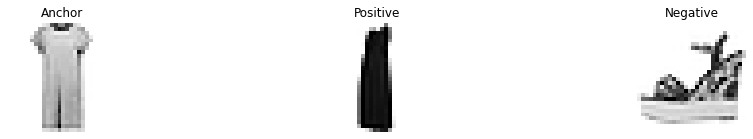

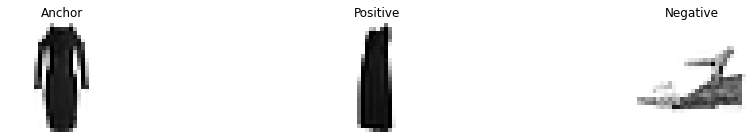

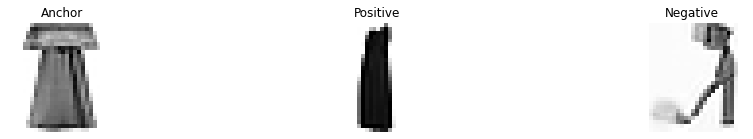

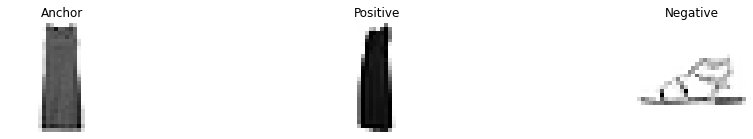

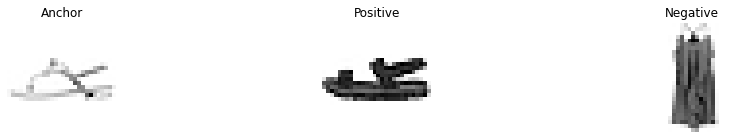

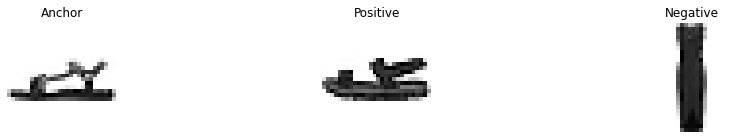

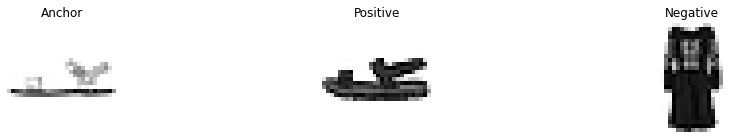

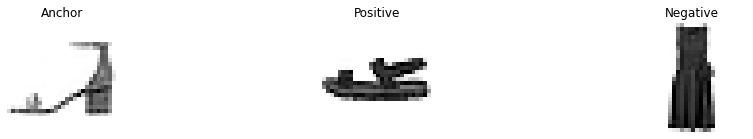

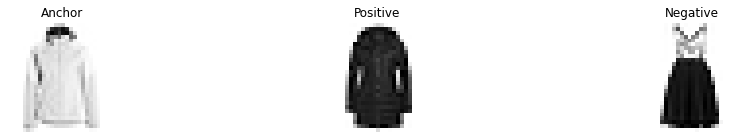

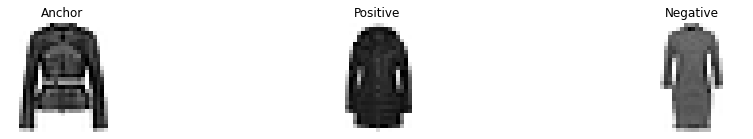

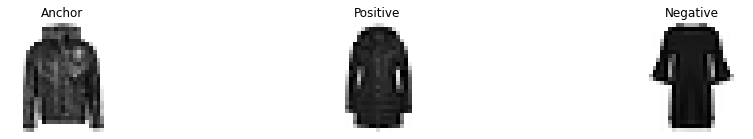

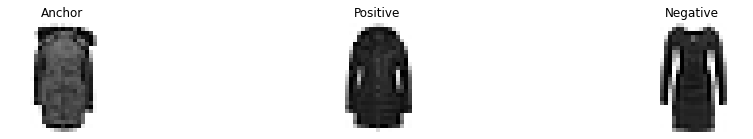

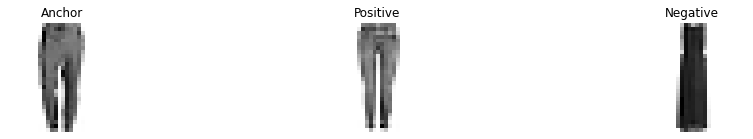

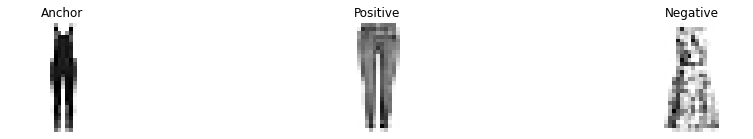

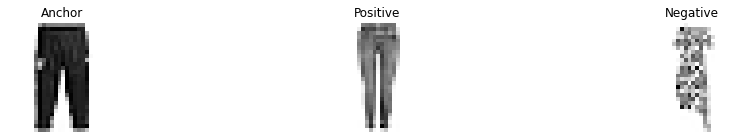

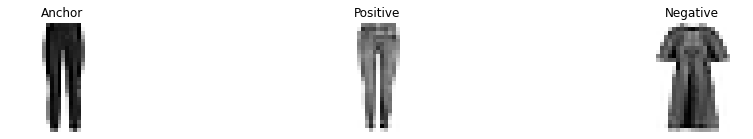

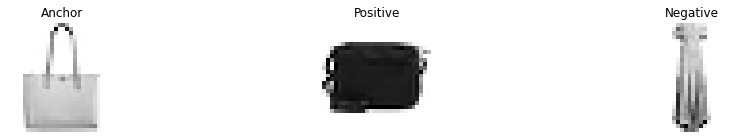

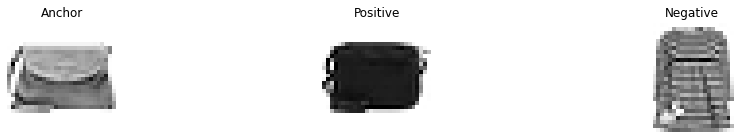

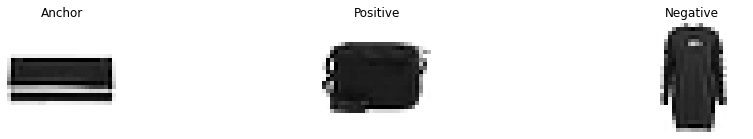

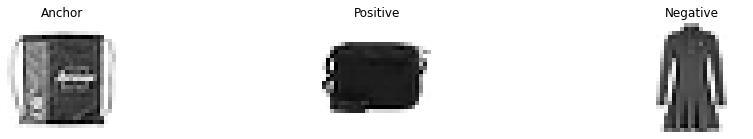

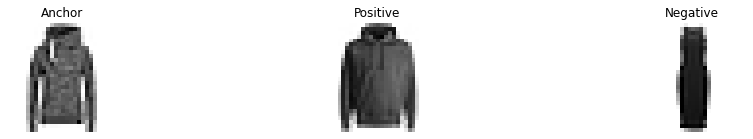

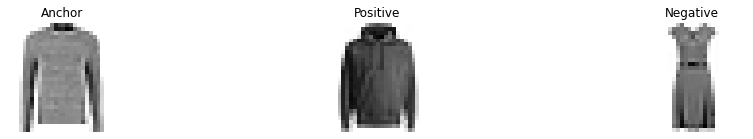

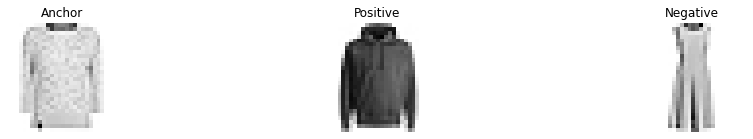

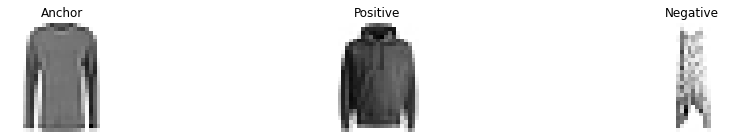

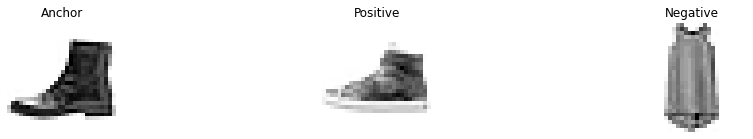

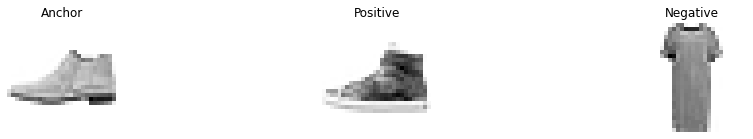

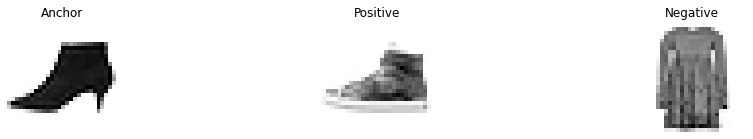

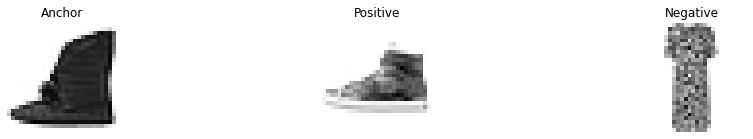

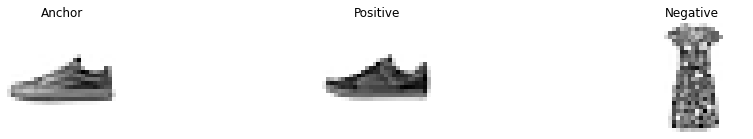

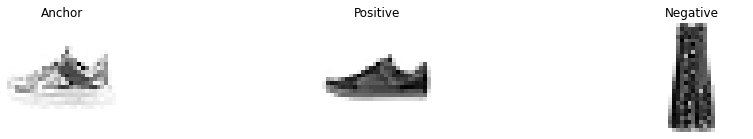

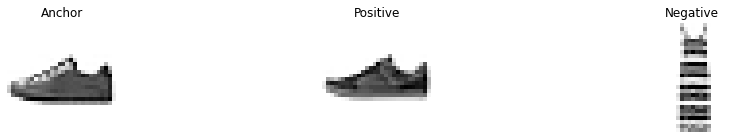

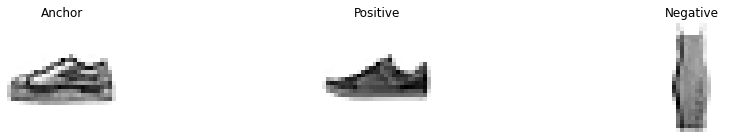

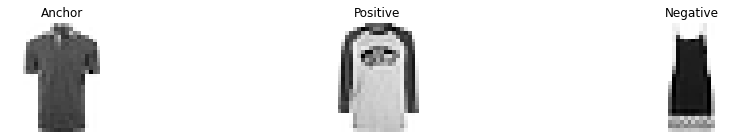

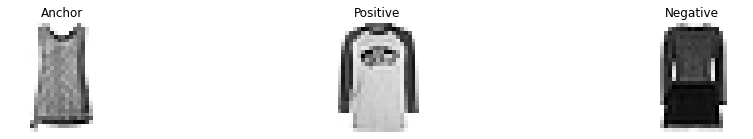

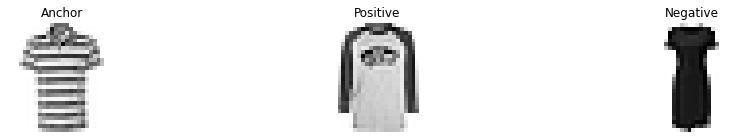

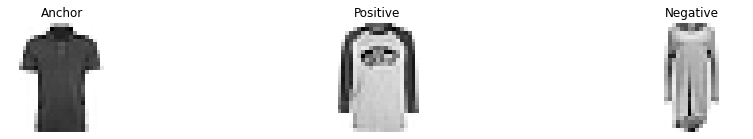

In [0]:
triplets = get_batch_moderate(12,model)
drawTriplets(triplets)

In [0]:
CMC = cumulative_matching_curve(x_test_origin,y_test_origin,model,1)

(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
(64,)
0.124


In [0]:
inter_dist = compute_interdist(model)
print(inter_dist)


[[  0.         120.01339722 398.2928772  ... 598.70098877 371.48931885
  737.97625732]
 [120.01339722   0.         144.54165649 ... 478.15609741 246.51008606
  571.08312988]
 [398.2928772  144.54165649   0.         ... 483.98950195 330.13873291
  519.56286621]
 ...
 [598.70098877 478.15609741 483.98950195 ...   0.          59.39736176
   17.40637779]
 [371.48931885 246.51008606 330.13873291 ...  59.39736176   0.
  113.35768127]
 [737.97625732 571.08312988 519.56286621 ...  17.40637779 113.35768127
    0.        ]]


Debuggage

In [0]:


import time


tf.keras.backend.clear_session()
model = build_network(input_shape,64)
model_trained = 0
model_trained = build_model_moderate(input_shape, model)

model_trained.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001))
n_val = 1000


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:236: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



 ------------- 

loss = 0.18179337680339813


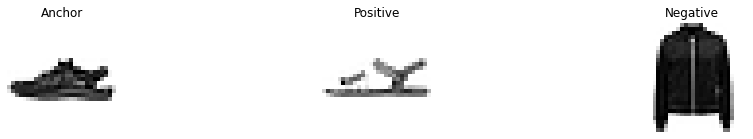

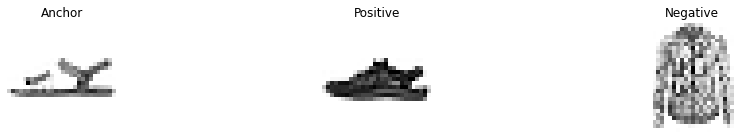

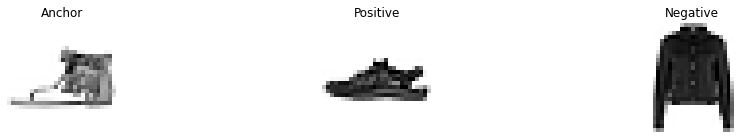

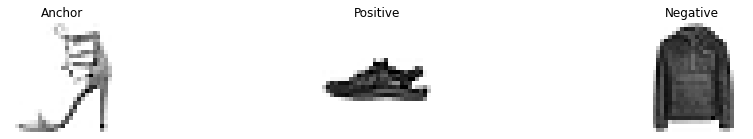

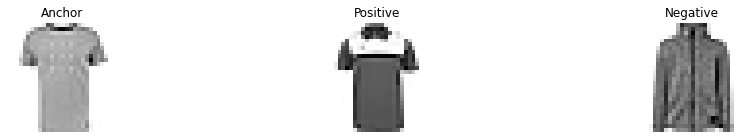

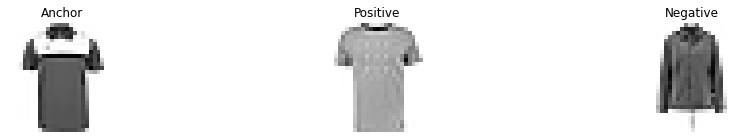

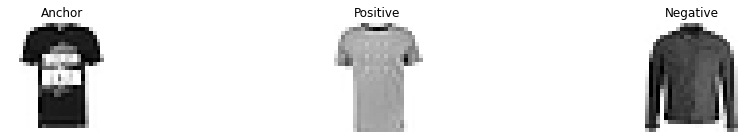

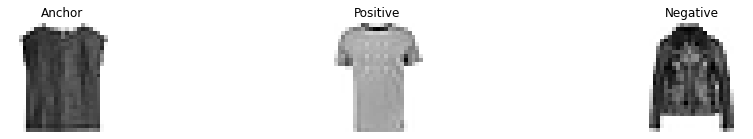

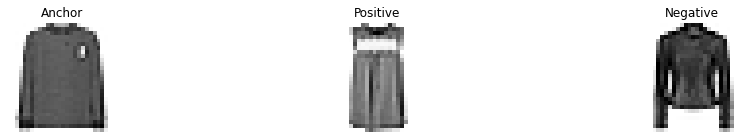

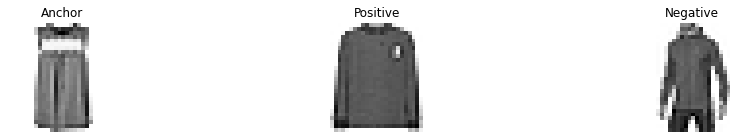

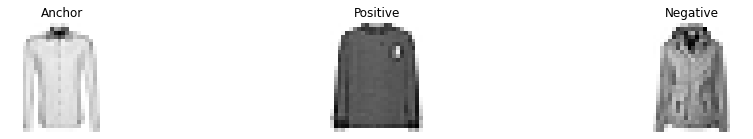

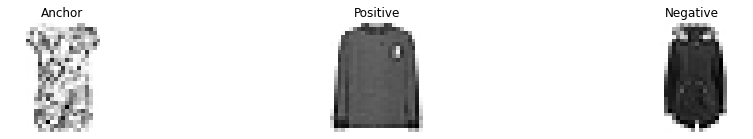

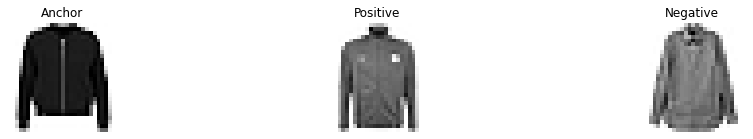

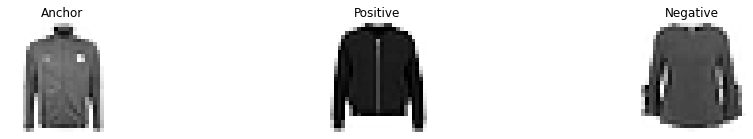

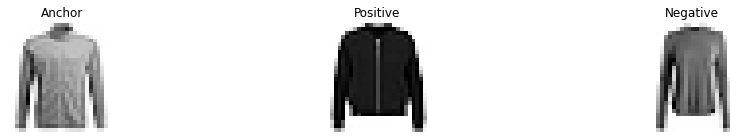

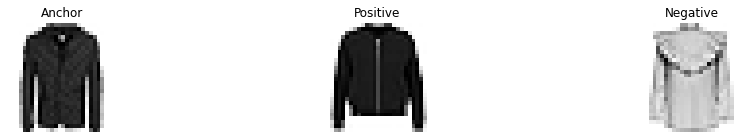

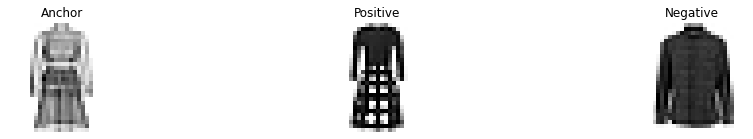

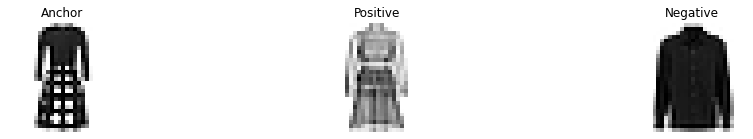

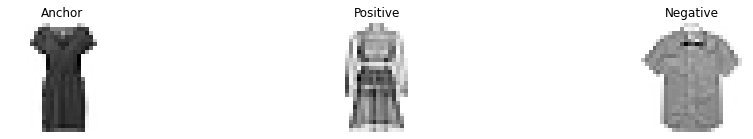

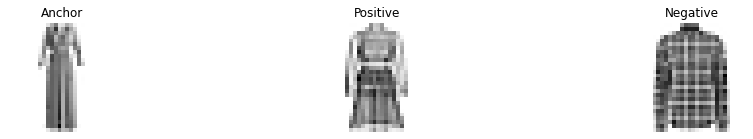

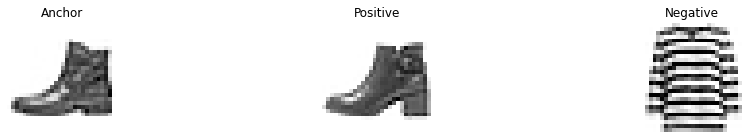

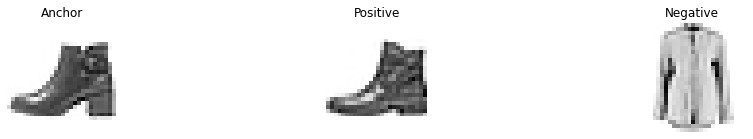

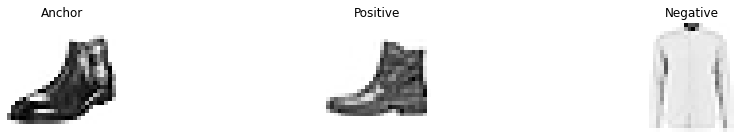

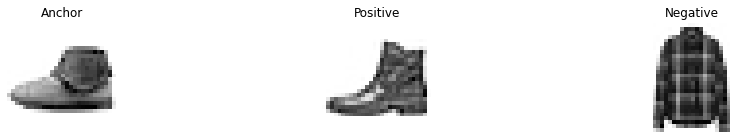

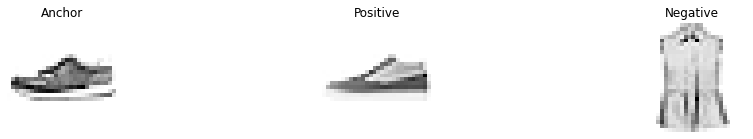

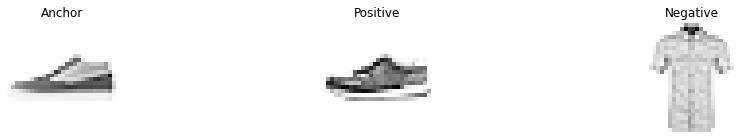

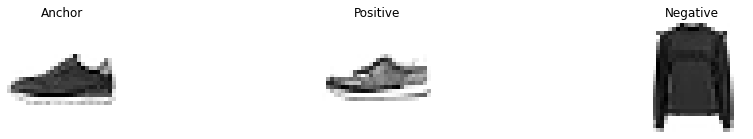

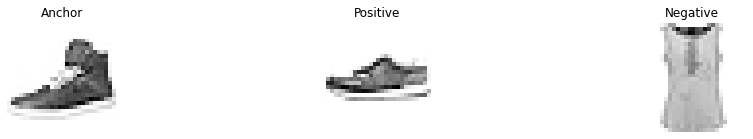

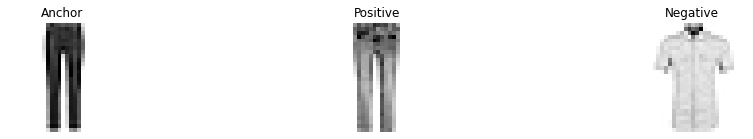

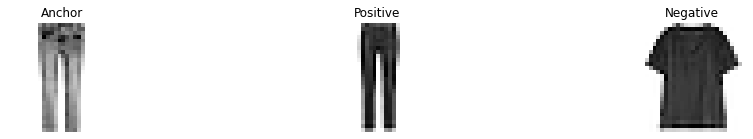

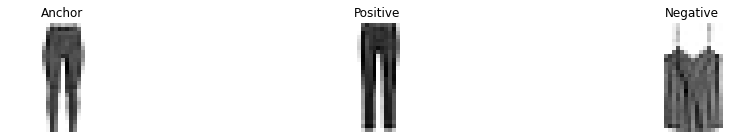

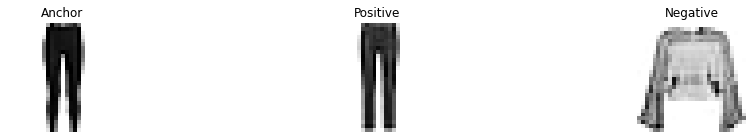

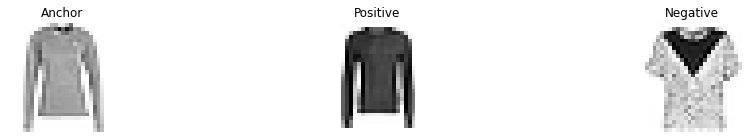

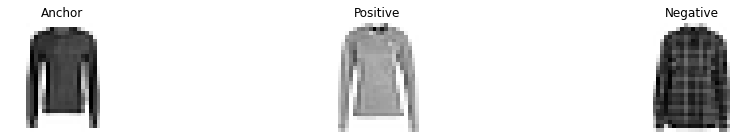

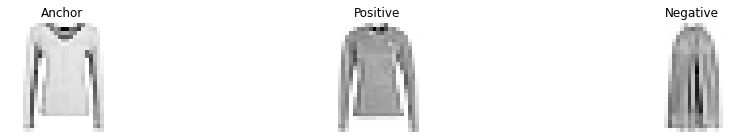

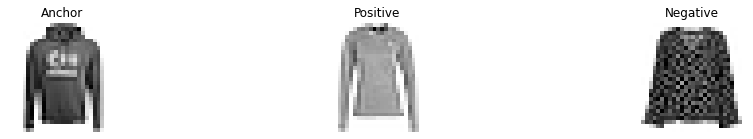

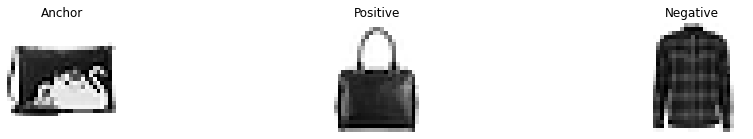

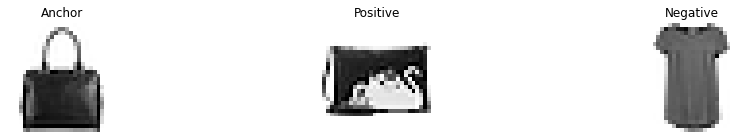

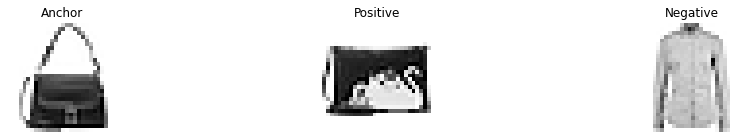

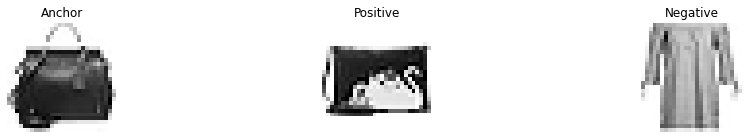

In [0]:
triplets = get_batch_moderate(14,model)
drawTriplets(tripletbatch=triplets)
#print(triplets.shape)
loss = model_trained.train_on_batch(triplets, None)

print("\n ------------- \n")
print("loss = " + str(loss))
probs,yprob = compute_probs(model,x_test_origin[:n_val,:,:,:],y_test_origin[:n_val])


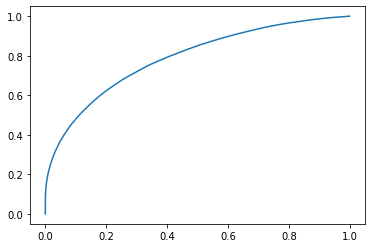

In [0]:
#compute_interdist(model)
probs,yprob = compute_probs(model,x_test_origin[:n_val,:,:,:],y_test_origin[:n_val])
fpr, tpr, thresholds,auc = compute_metrics(probs, yprob)

plt.figure()
plt.plot(fpr,tpr)

#plt.plot(thresholds)
